In [1]:
# ============================================================================
# SEKCJA 1: IMPORT BIBLIOTEK
# ============================================================================
# Cel: Załadowanie wszystkich potrzebnych narzędzi do trenowania modelu
# ============================================================================

import pandas as pd
import numpy as np
import pickle
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Biblioteki Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Biblioteki wizualizacji
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Konfiguracja wizualizacji
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("🤖 SYSTEM TRENOWANIA MODELU AI - ATLAS MATERIAL HANDLERS")
print("="*80)
print("✅ Wszystkie biblioteki załadowane pomyślnie!")
print(f"📅 Data i czas: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🐍 Pandas: {pd.__version__}")
print(f"🔢 NumPy: {np.__version__}")
print("="*80)

print("\n💡 INTERPRETACJA:")
print("   • pandas - do pracy z tabelami danych")
print("   • numpy - do obliczeń matematycznych")
print("   • sklearn - główna biblioteka machine learning")
print("   • Ridge - algorytm regresji z regularyzacją")
print("   • matplotlib/seaborn - do wykresów i wizualizacji")
print("   • pickle - do zapisywania wytrenowanego modelu")
print("\n✅ Środowisko gotowe do trenowania!")
print("="*80 + "\n")

🤖 SYSTEM TRENOWANIA MODELU AI - ATLAS MATERIAL HANDLERS
✅ Wszystkie biblioteki załadowane pomyślnie!
📅 Data i czas: 2025-10-09 18:59:44
🐍 Pandas: 2.1.3
🔢 NumPy: 1.25.2

💡 INTERPRETACJA:
   • pandas - do pracy z tabelami danych
   • numpy - do obliczeń matematycznych
   • sklearn - główna biblioteka machine learning
   • Ridge - algorytm regresji z regularyzacją
   • matplotlib/seaborn - do wykresów i wizualizacji
   • pickle - do zapisywania wytrenowanego modelu

✅ Środowisko gotowe do trenowania!



In [2]:
# ============================================================================
# SEKCJA 2: WCZYTANIE DANYCH TRENINGOWYCH
# ============================================================================
# Cel: Załadowanie danych z CSV i podstawowa inspekcja
# ============================================================================

print("📂 SEKCJA 2: WCZYTANIE DANYCH")
print("="*80)

try:
    # Wczytanie pliku CSV
    df = pd.read_csv('../data/material_handlers_training.csv')
    
    print(f"✅ Dane wczytane pomyślnie!")
    print(f"📊 Liczba obserwacji (wierszy): {len(df):,}")
    print(f"📋 Liczba kolumn: {len(df.columns)}")
    
    # Wyświetl nazwy kolumn z typami danych
    print(f"\n🔍 KOLUMNY W DANYCH ({len(df.columns)}):")
    print("-"*80)
    for i, col in enumerate(df.columns, 1):
        dtype = df[col].dtype
        nunique = df[col].nunique()
        print(f"   {i:2d}. {col:30s} | Typ: {str(dtype):10s} | Unikalnych: {nunique:>5,}")
    
    # Pierwsze 5 wierszy
    print(f"\n📋 PODGLĄD PIERWSZYCH 5 OBSERWACJI:")
    print("-"*80)
    print(df.head(5).to_string())
    
    # Informacje o pamięci
    memory_usage = df.memory_usage(deep=True).sum() / 1024**2
    print(f"\n💾 Rozmiar w pamięci: {memory_usage:.2f} MB")
    
except FileNotFoundError:
    print("❌ BŁĄD: Plik nie został znaleziony!")
    print("   Sprawdź ścieżkę: ../data/material_handlers_training.csv")
    print("   Czy uruchomiłeś notebook 01_generate_data.ipynb?")
    raise
except Exception as e:
    print(f"❌ BŁĄD podczas wczytywania: {str(e)}")
    raise

print("\n💡 INTERPRETACJA:")
print("   • Dane zawierają informacje o maszynach Atlas (modele, wiek, stan)")
print("   • Każdy wiersz = jedna maszyna z jej parametrami")
print("   • Kolumna 'price' = to co chcemy przewidzieć (target)")
print("   • Pozostałe kolumny = cechy (features) opisujące maszynę")
print(f"   • Mamy {len(df):,} przykładów do nauczenia modelu")
print("\n✅ Dane gotowe do analizy!")
print("="*80 + "\n")

📂 SEKCJA 2: WCZYTANIE DANYCH
✅ Dane wczytane pomyślnie!
📊 Liczba obserwacji (wierszy): 543
📋 Liczba kolumn: 18

🔍 KOLUMNY W DANYCH (18):
--------------------------------------------------------------------------------
    1. model                          | Typ: object     | Unikalnych:    10
    2. brand                          | Typ: object     | Unikalnych:     1
    3. tonnage                        | Typ: float64    | Unikalnych:    10
    4. engine_power_kw                | Typ: int64      | Unikalnych:     5
    5. reach_m                        | Typ: float64    | Unikalnych:     8
    6. base_price_new                 | Typ: int64      | Unikalnych:    10
    7. is_hybrid                      | Typ: bool       | Unikalnych:     2
    8. year                           | Typ: int64      | Unikalnych:    15
    9. hours                          | Typ: int64      | Unikalnych:   539
   10. hours_per_year                 | Typ: float64    | Unikalnych:   529
   11. condition      

In [3]:
# ============================================================================
# SEKCJA 3: WALIDACJA JAKOŚCI DANYCH
# ============================================================================
# Cel: Sprawdzenie czy dane są kompletne i poprawne
# ============================================================================

print("🔍 SEKCJA 3: WALIDACJA JAKOŚCI DANYCH")
print("="*80)

# 3.1 Sprawdzenie brakujących wartości (NULL/NaN)
print("\n📊 3.1 SPRAWDZANIE BRAKÓW DANYCH...")
print("-"*80)
null_counts = df.isnull().sum()
total_nulls = null_counts.sum()

if total_nulls > 0:
    print(f"⚠️ UWAGA: Znaleziono {total_nulls} wartości NULL!")
    print("\n   Rozkład braków:")
    for col, count in null_counts[null_counts > 0].items():
        pct = count / len(df) * 100
        print(f"      • {col}: {count} braków ({pct:.1f}%)")
    
    print(f"\n🔧 Usuwanie wierszy z brakami...")
    df_before = len(df)
    df = df.dropna()
    df_after = len(df)
    print(f"   ✅ Usunięto {df_before - df_after} wierszy")
    print(f"   ✅ Pozostało: {df_after:,} obserwacji")
else:
    print("✅ Brak wartości NULL - dane są kompletne!")
    print(f"   Wszystkie {len(df):,} wiersze mają pełne dane")

# 3.2 Sprawdzenie duplikatów
print("\n📊 3.2 SPRAWDZANIE DUPLIKATÓW...")
print("-"*80)
duplicates = df.duplicated().sum()

if duplicates > 0:
    print(f"⚠️ UWAGA: Znaleziono {duplicates} zduplikowanych wierszy")
    df_before = len(df)
    df = df.drop_duplicates()
    df_after = len(df)
    print(f"   ✅ Usunięto {df_before - df_after} duplikatów")
    print(f"   ✅ Pozostało: {df_after:,} unikalnych obserwacji")
else:
    print(f"✅ Brak duplikatów - wszystkie {len(df):,} obserwacji są unikalne")

# 3.3 Statystyki opisowe zmiennych numerycznych
print("\n📊 3.3 STATYSTYKI OPISOWE ZMIENNYCH NUMERYCZNYCH:")
print("-"*80)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
stats_df = df[numeric_cols].describe()
print(stats_df.to_string())

# 3.4 Analiza outlierów w price (metoda IQR)
print("\n📊 3.4 ANALIZA OUTLIERÓW W CENIE (metoda IQR)...")
print("-"*80)

Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_mask = (df['price'] < lower_bound) | (df['price'] > upper_bound)
outliers_count = outliers_mask.sum()

print(f"   Q1 (25 percentyl):     {Q1:>12,.0f} zł")
print(f"   Q3 (75 percentyl):     {Q3:>12,.0f} zł")
print(f"   IQR (rozstęp):         {IQR:>12,.0f} zł")
print(f"   Dolna granica:         {lower_bound:>12,.0f} zł")
print(f"   Górna granica:         {upper_bound:>12,.0f} zł")
print(f"   Outliers znalezione:   {outliers_count:>12,} ({outliers_count/len(df)*100:.1f}%)")

if outliers_count > 0:
    print(f"\n   💡 Outliers zostawiamy - mogą być realistyczne (drogie modele)")
    print(f"      np. Atlas 520MH może kosztować >1M zł")
else:
    print(f"\n   ✅ Brak outlierów - rozkład cen jest spójny")

# 3.5 Sprawdzenie typów danych
print("\n📊 3.5 SPRAWDZANIE TYPÓW DANYCH...")
print("-"*80)
print(f"   Zmienne numeryczne (int/float): {len(df.select_dtypes(include=['int64', 'float64']).columns)}")
print(f"   Zmienne tekstowe (object):      {len(df.select_dtypes(include=['object']).columns)}")
print(f"   Zmienne logiczne (bool):        {len(df.select_dtypes(include=['bool']).columns)}")

print("\n💡 INTERPRETACJA WALIDACJI:")
print("="*80)
print("   ✅ NULL values: Brak braków = model będzie miał pełne dane")
print("   ✅ Duplikaty: Brak duplikatów = każda obserwacja jest unikalna")
print("   ✅ Outliers: Ekstremalne ceny są OK (drogie modele)")
print("   ✅ Typy danych: Poprawne - liczby jako liczby, tekst jako tekst")
print("\n   📊 PODSUMOWANIE:")
print(f"      • Finalna liczba obserwacji: {len(df):,}")
print(f"      • Średnia cena: {df['price'].mean():,.0f} zł")
print(f"      • Zakres cen: {df['price'].min():,.0f} - {df['price'].max():,.0f} zł")
print(f"      • Dane są czyste i gotowe do modelowania!")
print("\n✅ Walidacja zakończona pomyślnie!")
print("="*80 + "\n")

🔍 SEKCJA 3: WALIDACJA JAKOŚCI DANYCH

📊 3.1 SPRAWDZANIE BRAKÓW DANYCH...
--------------------------------------------------------------------------------
✅ Brak wartości NULL - dane są kompletne!
   Wszystkie 543 wiersze mają pełne dane

📊 3.2 SPRAWDZANIE DUPLIKATÓW...
--------------------------------------------------------------------------------
✅ Brak duplikatów - wszystkie 543 obserwacji są unikalne

📊 3.3 STATYSTYKI OPISOWE ZMIENNYCH NUMERYCZNYCH:
--------------------------------------------------------------------------------
          tonnage  engine_power_kw     reach_m  base_price_new         year         hours  hours_per_year  condition_score  major_repairs  extra_attachments         price
count  543.000000       543.000000  543.000000    5.430000e+02   543.000000    543.000000      543.000000       543.000000     543.000000         543.000000  5.430000e+02
mean    30.961878       145.348066   14.470810    7.839963e+05  2017.079190   9284.685083     1177.233702         1.974

📊 SEKCJA 4: ANALIZA ROZKŁADU ZMIENNEJ DOCELOWEJ (PRICE)

📊 STATYSTYKI CENY:
--------------------------------------------------------------------------------
   Średnia (mean):                   364,902 zł
   Mediana (median):                 337,000 zł
   Odchylenie std (std):             167,084 zł
   Minimum:                           90,000 zł
   Maksimum:                       1,152,000 zł
   Rozstęp (range):                1,062,000 zł
   Współczynnik zmienności:             45.8%

📊 TEST NORMALNOŚCI ROZKŁADU (Shapiro-Wilk):
--------------------------------------------------------------------------------
   Statystyka testu: 0.9177
   P-value:          0.000000
   Próbka:           543 obserwacji

   ⚠️ Rozkład NIE jest normalny (p < 0.05)
      • To jest OK! Ceny maszyn często nie mają rozkładu normalnego
      • Ridge Regression radzi sobie z tym bez problemu

📊 KSZTAŁT ROZKŁADU:
--------------------------------------------------------------------------------
   Skewness (skośno

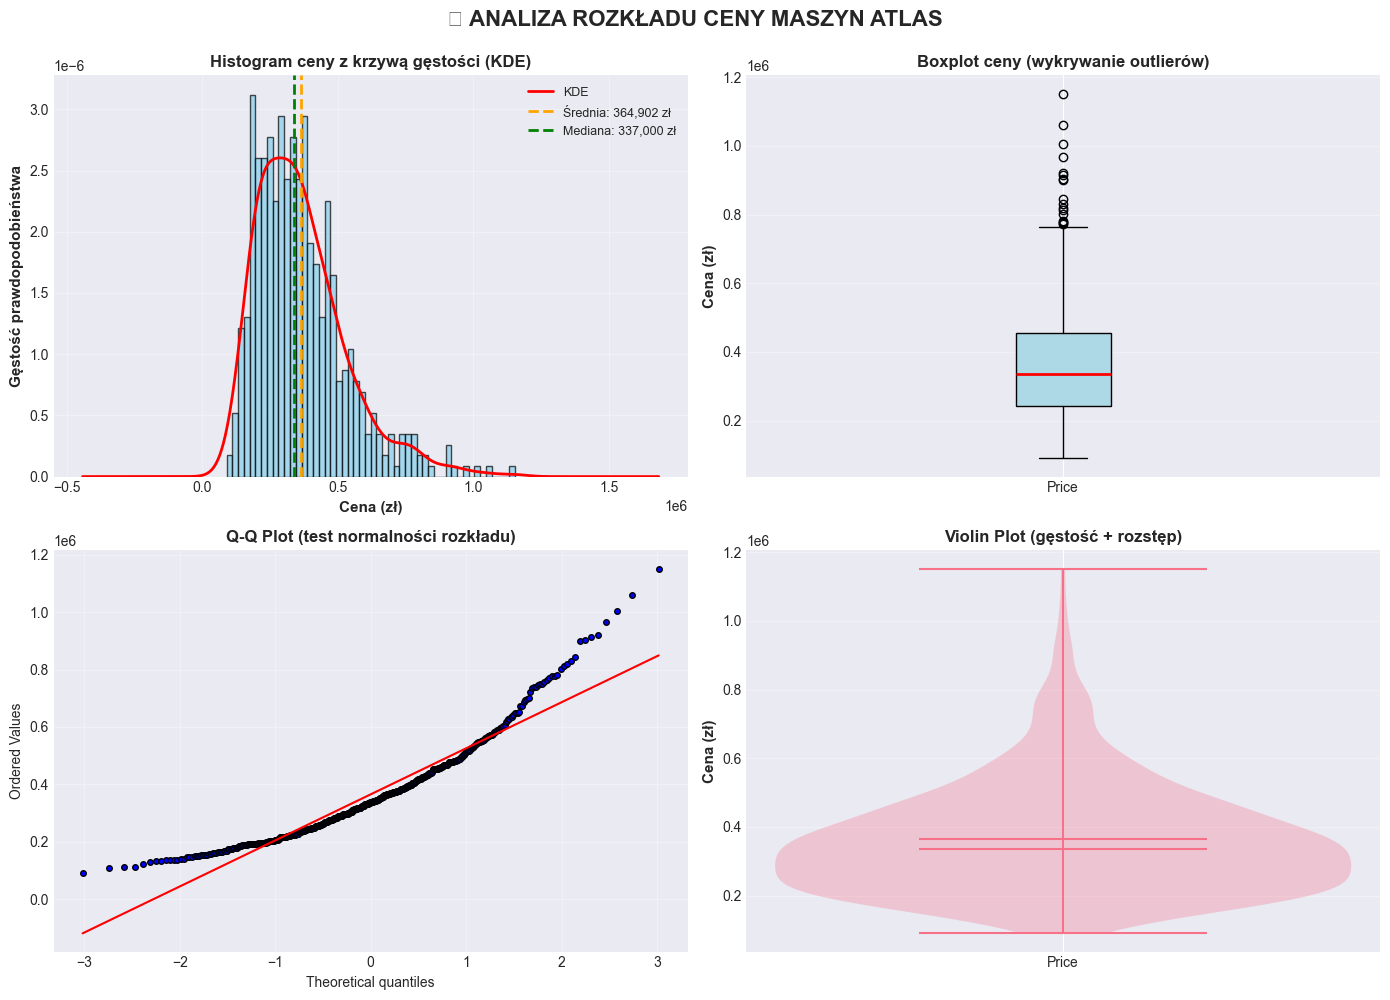

✅ Wykresy wygenerowane!

💡 INTERPRETACJA ROZKŁADU CENY:
   📊 Średnia vs Mediana:
      ⚠️ Różnica: 27,902 zł
         → Średnia > Mediana = rozkład prawostronnie skośny
         → Kilka bardzo drogich maszyn podciąga średnią w górę

   📊 Zmienność:
      ⚠️ Wysoka zmienność (45.8%) - duży rozstęp cen

   📊 Wnioski dla modelu:
      • Model będzie przewidywał ceny w zakresie 90,000 - 1,152,000 zł
      • Typowa cena: około 337,000 zł (mediana)
      • Outliers są OK - reprezentują drogie modele (np. 520MH)
      • Ridge Regression poradzi sobie z tym rozkładem

✅ Analiza rozkładu zakończona!



In [4]:
# ============================================================================
# SEKCJA 4: ANALIZA ROZKŁADU ZMIENNEJ DOCELOWEJ (PRICE)
# ============================================================================
# Cel: Zrozumienie jak wygląda rozkład cen - czy jest normalny, skośny, etc.
# ============================================================================

print("📊 SEKCJA 4: ANALIZA ROZKŁADU ZMIENNEJ DOCELOWEJ (PRICE)")
print("="*80)

# Statystyki ceny
mean_price = df['price'].mean()
median_price = df['price'].median()
std_price = df['price'].std()
min_price = df['price'].min()
max_price = df['price'].max()
cv = (std_price / mean_price) * 100  # Coefficient of Variation

print("\n📊 STATYSTYKI CENY:")
print("-"*80)
print(f"   Średnia (mean):           {mean_price:>15,.0f} zł")
print(f"   Mediana (median):         {median_price:>15,.0f} zł")
print(f"   Odchylenie std (std):     {std_price:>15,.0f} zł")
print(f"   Minimum:                  {min_price:>15,.0f} zł")
print(f"   Maksimum:                 {max_price:>15,.0f} zł")
print(f"   Rozstęp (range):          {max_price - min_price:>15,.0f} zł")
print(f"   Współczynnik zmienności:  {cv:>15.1f}%")

# Test normalności (Shapiro-Wilk)
print("\n📊 TEST NORMALNOŚCI ROZKŁADU (Shapiro-Wilk):")
print("-"*80)
# Dla dużych zbiorów używamy próbki (max 5000)
sample_size = min(5000, len(df))
sample_prices = df['price'].sample(sample_size, random_state=42)
statistic, p_value = stats.shapiro(sample_prices)

print(f"   Statystyka testu: {statistic:.4f}")
print(f"   P-value:          {p_value:.6f}")
print(f"   Próbka:           {sample_size:,} obserwacji")

if p_value < 0.05:
    print(f"\n   ⚠️ Rozkład NIE jest normalny (p < 0.05)")
    print(f"      • To jest OK! Ceny maszyn często nie mają rozkładu normalnego")
    print(f"      • Ridge Regression radzi sobie z tym bez problemu")
else:
    print(f"\n   ✅ Rozkład jest zbliżony do normalnego (p >= 0.05)")

# Skośność i kurtoza
skewness = df['price'].skew()
kurtosis = df['price'].kurtosis()

print(f"\n📊 KSZTAŁT ROZKŁADU:")
print("-"*80)
print(f"   Skewness (skośność):  {skewness:>8.2f}  ", end="")
if skewness > 0.5:
    print("(prawostronnie skośny - więcej niskich cen)")
elif skewness < -0.5:
    print("(lewostronnie skośny - więcej wysokich cen)")
else:
    print("(rozkład symetryczny)")

print(f"   Kurtosis (spłaszczenie): {kurtosis:>8.2f}  ", end="")
if kurtosis > 0:
    print("(bardziej wysmukły niż normalny)")
else:
    print("(bardziej spłaszczony niż normalny)")

# WIZUALIZACJA
print("\n📊 TWORZENIE WYKRESÓW ROZKŁADU...")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('📊 ANALIZA ROZKŁADU CENY MASZYN ATLAS', fontsize=16, fontweight='bold', y=0.995)

# 4.1 Histogram z krzywą KDE
axes[0, 0].hist(df['price'], bins=50, edgecolor='black', alpha=0.7, color='skyblue', density=True)
df['price'].plot(kind='kde', ax=axes[0, 0], linewidth=2, color='red', label='KDE')
axes[0, 0].axvline(mean_price, color='orange', linestyle='--', linewidth=2, label=f'Średnia: {mean_price:,.0f} zł')
axes[0, 0].axvline(median_price, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_price:,.0f} zł')
axes[0, 0].set_xlabel('Cena (zł)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Gęstość prawdopodobieństwa', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Histogram ceny z krzywą gęstości (KDE)', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(True, alpha=0.3)

# 4.2 Boxplot
box = axes[0, 1].boxplot(df['price'], vert=True, patch_artist=True, 
                          boxprops=dict(facecolor='lightblue', color='black'),
                          medianprops=dict(color='red', linewidth=2),
                          whiskerprops=dict(color='black'),
                          capprops=dict(color='black'))
axes[0, 1].set_ylabel('Cena (zł)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Boxplot ceny (wykrywanie outlierów)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_xticklabels(['Price'])

# 4.3 Q-Q Plot (normalność)
stats.probplot(df['price'], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (test normalności rozkładu)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].get_lines()[0].set_markerfacecolor('blue')
axes[1, 0].get_lines()[0].set_markeredgecolor('black')
axes[1, 0].get_lines()[0].set_markersize(4)

# 4.4 Violin plot
parts = axes[1, 1].violinplot([df['price']], positions=[0], showmeans=True, showmedians=True)
axes[1, 1].set_ylabel('Cena (zł)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Violin Plot (gęstość + rozstęp)', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks([0])
axes[1, 1].set_xticklabels(['Price'])
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✅ Wykresy wygenerowane!")

print("\n💡 INTERPRETACJA ROZKŁADU CENY:")
print("="*80)
print(f"   📊 Średnia vs Mediana:")
if abs(mean_price - median_price) / mean_price < 0.05:
    print(f"      ✅ Bardzo zbliżone ({abs(mean_price - median_price):,.0f} zł różnicy)")
    print(f"         → Rozkład symetryczny, brak silnej skośności")
else:
    print(f"      ⚠️ Różnica: {abs(mean_price - median_price):,.0f} zł")
    if mean_price > median_price:
        print(f"         → Średnia > Mediana = rozkład prawostronnie skośny")
        print(f"         → Kilka bardzo drogich maszyn podciąga średnią w górę")
    else:
        print(f"         → Średnia < Mediana = rozkład lewostronnie skośny")

print(f"\n   📊 Zmienność:")
if cv < 20:
    print(f"      ✅ Niska zmienność ({cv:.1f}%) - ceny są spójne")
elif cv < 40:
    print(f"      ⚠️ Średnia zmienność ({cv:.1f}%) - różnorodność modeli")
else:
    print(f"      ⚠️ Wysoka zmienność ({cv:.1f}%) - duży rozstęp cen")

print(f"\n   📊 Wnioski dla modelu:")
print(f"      • Model będzie przewidywał ceny w zakresie {min_price:,.0f} - {max_price:,.0f} zł")
print(f"      • Typowa cena: około {median_price:,.0f} zł (mediana)")
print(f"      • Outliers są OK - reprezentują drogie modele (np. 520MH)")
print(f"      • Ridge Regression poradzi sobie z tym rozkładem")

print("\n✅ Analiza rozkładu zakończona!")
print("="*80 + "\n")

In [5]:
# ============================================================================
# SEKCJA 5: FEATURE ENGINEERING - OBLICZENIE WIEKU MASZYNY
# ============================================================================
# Cel: Utworzenie kolumny 'age' (wiek) z kolumny 'year' (rok produkcji)
# ============================================================================

print("🔧 SEKCJA 5: FEATURE ENGINEERING - OBLICZENIE WIEKU")
print("="*80)

# Obecny rok (dla wyceny)
current_year = 2025

print(f"\n📅 Rok bazowy: {current_year}")
print("-"*80)

# Sprawdź zakres lat produkcji
print(f"   Najstarsza maszyna: {df['year'].min()}")
print(f"   Najnowsza maszyna:  {df['year'].max()}")
print(f"   Rozstęp lat:        {df['year'].max() - df['year'].min()} lat")

# Oblicz age (wiek maszyny w latach)
df['age'] = current_year - df['year']

print(f"\n✅ Utworzono kolumnę 'age' (wiek maszyny)")
print("-"*80)

# Statystyki wieku
print(f"   Najmłodsza (age min):    {df['age'].min()} lat")
print(f"   Najstarsza (age max):    {df['age'].max()} lat")
print(f"   Średni wiek:             {df['age'].mean():.1f} lat")
print(f"   Mediana wieku:           {df['age'].median():.0f} lat")

# Rozkład wieku
print(f"\n📊 ROZKŁAD WIEKU MASZYN:")
print("-"*80)
age_distribution = df['age'].value_counts().sort_index()
for age, count in age_distribution.items():
    pct = count / len(df) * 100
    bar = '█' * int(pct / 2)
    print(f"   {age:2d} lat: {count:3d} maszyn ({pct:5.1f}%) {bar}")

# Przykłady transformacji
print(f"\n🔍 PRZYKŁADY TRANSFORMACJI (year → age):")
print("-"*80)
print(f"   {'Year':<10} {'Age':<10} {'Interpretacja':<30}")
print("-"*80)
for year in sorted(df['year'].unique())[:5]:
    age = current_year - year
    if age <= 2:
        interpretation = "Prawie nowa"
    elif age <= 5:
        interpretation = "Młoda, dobry stan"
    elif age <= 10:
        interpretation = "Średni wiek"
    else:
        interpretation = "Starsza maszyna"
    print(f"   {year:<10} {age:<10} {interpretation:<30}")

# Korelacja age vs price
correlation = df[['age', 'price']].corr().iloc[0, 1]
print(f"\n📊 KORELACJA: age vs price")
print("-"*80)
print(f"   Współczynnik korelacji: {correlation:.4f}")

if correlation < -0.3:
    print(f"   ✅ SILNA NEGATYWNA korelacja")
    print(f"      → Starsze maszyny są ZNACZNIE tańsze")
elif correlation < -0.1:
    print(f"   ⚠️ SŁABA NEGATYWNA korelacja")
    print(f"      → Starsze maszyny są nieco tańsze")
elif correlation > 0.1:
    print(f"   ⚠️ POZYTYWNA korelacja (nietypowe!)")
    print(f"      → Starsze maszyny są droższe? Sprawdź dane!")
else:
    print(f"   ℹ️ BRAK korelacji")
    print(f"      → Wiek nie wpływa na cenę (inne czynniki ważniejsze)")

print("\n💡 INTERPRETACJA:")
print("="*80)
print("   ✅ DLACZEGO 'age' zamiast 'year'?")
print("      1. Model lepiej rozumie 'wiek' niż 'rok produkcji'")
print("      2. Age = 5 lat ma tę samą interpretację w 2025 i 2030")
print("      3. Year = 2020 ma inną interpretację w 2025 vs 2030")
print("      4. Age jest bardziej uniwersalne i skalowalne")
print("\n   ✅ CO DALEJ?")
print("      • Kolumna 'year' zostanie usunięta z features")
print("      • Kolumna 'age' zostanie użyta w modelu")
print("      • Model nauczy się: 'Im starsze → tym tańsze'")

print("\n✅ Feature Engineering zakończony!")
print("="*80 + "\n")

🔧 SEKCJA 5: FEATURE ENGINEERING - OBLICZENIE WIEKU

📅 Rok bazowy: 2025
--------------------------------------------------------------------------------
   Najstarsza maszyna: 2010
   Najnowsza maszyna:  2024
   Rozstęp lat:        14 lat

✅ Utworzono kolumnę 'age' (wiek maszyny)
--------------------------------------------------------------------------------
   Najmłodsza (age min):    1 lat
   Najstarsza (age max):    15 lat
   Średni wiek:             7.9 lat
   Mediana wieku:           8 lat

📊 ROZKŁAD WIEKU MASZYN:
--------------------------------------------------------------------------------
    1 lat:  39 maszyn (  7.2%) ███
    2 lat:  40 maszyn (  7.4%) ███
    3 lat:  38 maszyn (  7.0%) ███
    4 lat:  32 maszyn (  5.9%) ██
    5 lat:  36 maszyn (  6.6%) ███
    6 lat:  34 maszyn (  6.3%) ███
    7 lat:  27 maszyn (  5.0%) ██
    8 lat:  32 maszyn (  5.9%) ██
    9 lat:  46 maszyn (  8.5%) ████
   10 lat:  45 maszyn (  8.3%) ████
   11 lat:  37 maszyn (  6.8%) ███
   12 lat:

In [6]:
# ============================================================================
# SEKCJA 6: ONE-HOT ENCODING ZMIENNYCH KATEGORYCZNYCH
# ============================================================================
# Cel: Zamiana tekstowych kategorii na liczby (0 i 1) dla modelu ML
# ============================================================================

print("🔄 SEKCJA 6: ONE-HOT ENCODING ZMIENNYCH KATEGORYCZNYCH")
print("="*80)

print("\n📋 Identyfikacja zmiennych kategorycznych...")
print("-"*80)

# Sprawdź zmienne tekstowe (object)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"   Znalezione kolumny tekstowe ({len(categorical_cols)}):")
for col in categorical_cols:
    unique_count = df[col].nunique()
    print(f"      • {col:20s} → {unique_count} unikalnych wartości")

# Wyświetl wartości condition
print(f"\n📊 ZMIENNA: 'condition' (stan techniczny)")
print("-"*80)
print(f"   Unikalne wartości:")
for value, count in df['condition'].value_counts().items():
    pct = count / len(df) * 100
    print(f"      • {value:15s}: {count:4d} maszyn ({pct:5.1f}%)")

# Wyświetl wartości model
print(f"\n📊 ZMIENNA: 'model' (model maszyny)")
print("-"*80)
print(f"   Unikalne wartości:")
for value, count in df['model'].value_counts().sort_index().items():
    pct = count / len(df) * 100
    print(f"      • {value:15s}: {count:4d} maszyn ({pct:5.1f}%)")

# ONE-HOT ENCODING
print(f"\n🔧 WYKONYWANIE ONE-HOT ENCODING...")
print("-"*80)

# Przed encoding
cols_before = len(df.columns)
print(f"   Liczba kolumn przed encoding: {cols_before}")

# Wykonaj one-hot encoding dla 'condition' i 'model'
# WAŻNE: drop_first=False (zachowaj wszystkie kategorie dla przejrzystości)
df_encoded = pd.get_dummies(
    df, 
    columns=['condition', 'model'], 
    prefix=['condition', 'model'],
    drop_first=False  # Zachowaj wszystkie kategorie
)

# Po encoding
cols_after = len(df_encoded.columns)
print(f"   Liczba kolumn po encoding:    {cols_after}")
print(f"   Dodano kolumn:                {cols_after - cols_before}")

# Pokaż nowe kolumny
print(f"\n📋 NOWE KOLUMNY - CONDITION:")
print("-"*80)
condition_cols = [col for col in df_encoded.columns if col.startswith('condition_')]
for i, col in enumerate(condition_cols, 1):
    # Policz ile maszyn ma tę wartość
    count = df_encoded[col].sum()
    print(f"   {i}. {col:30s} → {int(count):4d} maszyn (gdzie 1)")

print(f"\n📋 NOWE KOLUMNY - MODEL:")
print("-"*80)
model_cols = [col for col in df_encoded.columns if col.startswith('model_')]
for i, col in enumerate(model_cols, 1):
    count = df_encoded[col].sum()
    print(f"   {i:2d}. {col:30s} → {int(count):4d} maszyn (gdzie 1)")

# Zapisz do df
df = df_encoded.copy()

# Przykład transformacji
print(f"\n🔍 PRZYKŁAD TRANSFORMACJI:")
print("-"*80)
print("Przed encoding:")
print("   condition = 'excellent' → model nie rozumie tekstu")
print("\nPo encoding:")
print("   condition_excellent = 1")
print("   condition_good = 0")
print("   condition_fair = 0")
print("   condition_poor = 0")
print("   → Model rozumie: ta maszyna ma 'excellent' condition!")

# Weryfikacja
print(f"\n✅ WERYFIKACJA:")
print("-"*80)

# Sprawdź czy suma w każdej grupie = 1 (dla każdego wiersza)
sample_row = df[condition_cols].iloc[0]
condition_sum = sample_row.sum()
print(f"   Suma kolumn condition dla przykładowego wiersza: {condition_sum}")
if condition_sum == 1:
    print(f"   ✅ Poprawnie! Każda maszyna ma dokładnie 1 stan techniczny")
else:
    print(f"   ⚠️ Błąd! Suma powinna być = 1")

sample_row_model = df[model_cols].iloc[0]
model_sum = sample_row_model.sum()
print(f"   Suma kolumn model dla przykładowego wiersza:     {model_sum}")
if model_sum == 1:
    print(f"   ✅ Poprawnie! Każda maszyna ma dokładnie 1 model")
else:
    print(f"   ⚠️ Błąd! Suma powinna być = 1")

print("\n💡 INTERPRETACJA:")
print("="*80)
print("   ✅ CZYM JEST ONE-HOT ENCODING?")
print("      • Transformacja tekstu → liczby (0 i 1)")
print("      • Każda kategoria dostaje własną kolumnę")
print("      • Wartość 1 = 'maszyna ma tę cechę'")
print("      • Wartość 0 = 'maszyna nie ma tej cechy'")
print("\n   ✅ DLACZEGO TO ROBIMY?")
print("      • Modele ML rozumieją tylko liczby!")
print("      • Nie można dać 'excellent' bezpośrednio do modelu")
print("      • One-hot encoding rozwiązuje ten problem")
print("\n   ✅ PRZYKŁAD BIZNESOWY:")
print("      • Atlas 200MH + excellent → model_200MH=1, condition_excellent=1")
print("      • Te zmienne będą miały silny pozytywny wpływ na cenę!")

print(f"\n✅ Encoding zakończony! Dane gotowe do podziału train/test.")
print("="*80 + "\n")

🔄 SEKCJA 6: ONE-HOT ENCODING ZMIENNYCH KATEGORYCZNYCH

📋 Identyfikacja zmiennych kategorycznych...
--------------------------------------------------------------------------------
   Znalezione kolumny tekstowe (3):
      • model                → 10 unikalnych wartości
      • brand                → 1 unikalnych wartości
      • condition            → 5 unikalnych wartości

📊 ZMIENNA: 'condition' (stan techniczny)
--------------------------------------------------------------------------------
   Unikalne wartości:
      • Doskonały      :  112 maszyn ( 20.6%)
      • Dobry          :  110 maszyn ( 20.3%)
      • Bardzo dobry   :  110 maszyn ( 20.3%)
      • Wymaga naprawy :  109 maszyn ( 20.1%)
      • Zadowalający   :  102 maszyn ( 18.8%)

📊 ZMIENNA: 'model' (model maszyny)
--------------------------------------------------------------------------------
   Unikalne wartości:
      • 160MH          :   56 maszyn ( 10.3%)
      • 180MH          :   55 maszyn ( 10.1%)
      • 200MH     

In [7]:
# ============================================================================
# SEKCJA 7: PRZYGOTOWANIE FEATURES (X) i TARGET (y)
# ============================================================================
# Cel: Podział danych na zmienne wejściowe (X) i wyjściowe (y)
# ============================================================================

print("🎯 SEKCJA 7: PRZYGOTOWANIE FEATURES (X) i TARGET (y)")
print("="*80)

print("\n📋 KROK 1: Identyfikacja kolumn do wykluczenia z modelu")
print("-"*80)

# Kolumny do WYKLUCZENIA z features (X)
exclude_cols = [
    'price',    # TARGET - to przewidujemy
    'year',     # Zastąpione przez 'age'
    'brand'     # Identyfikator (wszystko to Atlas)
]

print(f"   Kolumny do wykluczenia ({len(exclude_cols)}):")
for col in exclude_cols:
    if col == 'price':
        reason = "← TARGET (zmiennavdocelowa - to przewidujemy)"
    elif col == 'year':
        reason = "← Zastąpione przez 'age'"
    elif col == 'brand':
        reason = "← Identyfikator (wszystko to Atlas)"
    else:
        reason = "← Nie używamy w modelu"
    print(f"      • {col:20s} {reason}")

print(f"\n📋 KROK 2: Wybór kolumn features (X)")
print("-"*80)

# Features = wszystkie kolumny oprócz wykluczonych
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"   Liczba features: {len(feature_cols)}")
print(f"\n   Lista features:")

# Grupuj features według typu
numeric_features = []
condition_features = []
model_features = []
other_features = []

for col in feature_cols:
    if col.startswith('condition_'):
        condition_features.append(col)
    elif col.startswith('model_'):
        model_features.append(col)
    elif df[col].dtype in ['int64', 'float64', 'bool']:
        numeric_features.append(col)
    else:
        other_features.append(col)

print(f"\n   📊 Zmienne numeryczne ({len(numeric_features)}):")
for i, col in enumerate(numeric_features, 1):
    dtype = 'float' if df[col].dtype == 'float64' else 'int' if df[col].dtype == 'int64' else 'bool'
    print(f"      {i:2d}. {col:30s} ({dtype})")

print(f"\n   📊 Zmienne condition ({len(condition_features)}):")
for i, col in enumerate(condition_features, 1):
    print(f"      {i:2d}. {col:30s} (binary: 0/1)")

print(f"\n   📊 Zmienne model ({len(model_features)}):")
for i, col in enumerate(model_features, 1):
    print(f"      {i:2d}. {col:30s} (binary: 0/1)")

if len(other_features) > 0:
    print(f"\n   📊 Inne features ({len(other_features)}):")
    for i, col in enumerate(other_features, 1):
        print(f"      {i:2d}. {col:30s}")

print(f"\n📋 KROK 3: Utworzenie X i y")
print("-"*80)

# X = features (dane wejściowe)
X = df[feature_cols].copy()

# y = target (dane wyjściowe - cena)
y = df['price'].copy()

print(f"   ✅ X (features) utworzone:")
print(f"      • Shape: {X.shape} (wiersze, kolumny)")
print(f"      • Typ: {type(X)}")
print(f"      • Pamięć: {X.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\n   ✅ y (target) utworzone:")
print(f"      • Shape: {y.shape}")
print(f"      • Typ: {type(y)}")
print(f"      • Średnia cena: {y.mean():,.0f} zł")
print(f"      • Min/Max: {y.min():,.0f} - {y.max():,.0f} zł")

print(f"\n📋 KROK 4: Weryfikacja poprawności")
print("-"*80)

# Sprawdź czy 'year' NIE MA w X (poprawnie)
if 'year' in X.columns:
    print(f"   ❌ BŁĄD: 'year' jest w X - nie powinno być!")
else:
    print(f"   ✅ 'year' nie ma w X - poprawnie!")

# Sprawdź czy 'age' JEST w X (poprawnie)
if 'age' in X.columns:
    print(f"   ✅ 'age' jest w X - poprawnie!")
else:
    print(f"   ❌ BŁĄD: 'age' nie ma w X - powinno być!")

# Sprawdź czy 'model' JEST w X (jako one-hot encoded)
model_cols_in_x = [col for col in X.columns if col.startswith('model_')]
if len(model_cols_in_x) > 0:
    print(f"   ✅ 'model' jest w X (jako {len(model_cols_in_x)} kolumn one-hot) - poprawnie!")
else:
    print(f"   ❌ BŁĄD: 'model' nie ma w X - powinno być!")

# Sprawdź czy 'price' NIE MA w X (poprawnie)
if 'price' in X.columns:
    print(f"   ❌ BŁĄD: 'price' jest w X - nie powinno być! (to target)")
else:
    print(f"   ✅ 'price' nie ma w X - poprawnie! (to jest y)")

# Sprawdź czy X i y mają tę samą długość
if len(X) == len(y):
    print(f"   ✅ X i y mają tę samą długość ({len(X):,}) - poprawnie!")
else:
    print(f"   ❌ BŁĄD: X ({len(X)}) i y ({len(y)}) mają różne długości!")

print(f"\n📋 PODGLĄD X (pierwsze 3 wiersze):")
print("-"*80)
print(X.head(3).to_string())

print(f"\n📋 PODGLĄD y (pierwsze 10 wartości):")
print("-"*80)
print(y.head(10).to_string())

print("\n💡 INTERPRETACJA:")
print("="*80)
print("   ✅ CZYM JEST X (features)?")
print("      • Dane wejściowe dla modelu")
print("      • Wszystkie cechy opisujące maszynę")
print("      • Np. wiek, motogodziny, stan, model, wyposażenie")
print("      • Model używa X do przewidywania ceny")
print("\n   ✅ CZYM JEST y (target)?")
print("      • Dane wyjściowe (to co przewidujemy)")
print("      • W naszym przypadku: cena maszyny")
print("      • Model uczy się: dla danego X → przewiduj y")
print("\n   ✅ PRZYKŁAD:")
print("      • X = [Atlas 200MH, 5 lat, 3000h, excellent, klimatyzacja]")
print("      • y = 350,000 zł")
print("      • Model nauczy się: takie X → taka y")
print(f"\n   📊 PODSUMOWANIE:")
print(f"      • {len(X):,} obserwacji (maszyn)")
print(f"      • {len(feature_cols)} features (cech)")
print(f"      • 1 target (cena)")
print(f"      • Dane gotowe do podziału train/test!")

print("\n✅ Przygotowanie X i y zakończone!")
print("="*80 + "\n")

🎯 SEKCJA 7: PRZYGOTOWANIE FEATURES (X) i TARGET (y)

📋 KROK 1: Identyfikacja kolumn do wykluczenia z modelu
--------------------------------------------------------------------------------
   Kolumny do wykluczenia (3):
      • price                ← TARGET (zmiennavdocelowa - to przewidujemy)
      • year                 ← Zastąpione przez 'age'
      • brand                ← Identyfikator (wszystko to Atlas)

📋 KROK 2: Wybór kolumn features (X)
--------------------------------------------------------------------------------
   Liczba features: 29

   Lista features:

   📊 Zmienne numeryczne (13):
       1. tonnage                        (float)
       2. engine_power_kw                (int)
       3. reach_m                        (float)
       4. base_price_new                 (int)
       5. is_hybrid                      (bool)
       6. hours                          (int)
       7. hours_per_year                 (float)
       8. full_service_history           (bool)
       9. 

✂️ SEKCJA 8: PODZIAŁ NA ZBIÓR TRENINGOWY I TESTOWY

📋 PARAMETRY PODZIAŁU:
--------------------------------------------------------------------------------
   Test size:     0.2 (20%)
   Train size:    0.8 (80%)
   Random state:  42 (dla powtarzalności)
   Shuffle:       True (losowe mieszanie)

🔧 WYKONYWANIE PODZIAŁU...
--------------------------------------------------------------------------------
   ✅ Podział wykonany!

📊 ROZMIARY ZBIORÓW:
--------------------------------------------------------------------------------
   Zbiór           Liczba obs.     Procent    Shape          
--------------------------------------------------------------------------------
   TRAIN                    434      79.9%   (434, 29)      
   TEST                     109      20.1%   (109, 29)      
   TOTAL                    543     100.0%   (543, 29)      

📊 STATYSTYKI TARGET (CENA) w zbiorach:
--------------------------------------------------------------------------------
   Zbiór           Średni

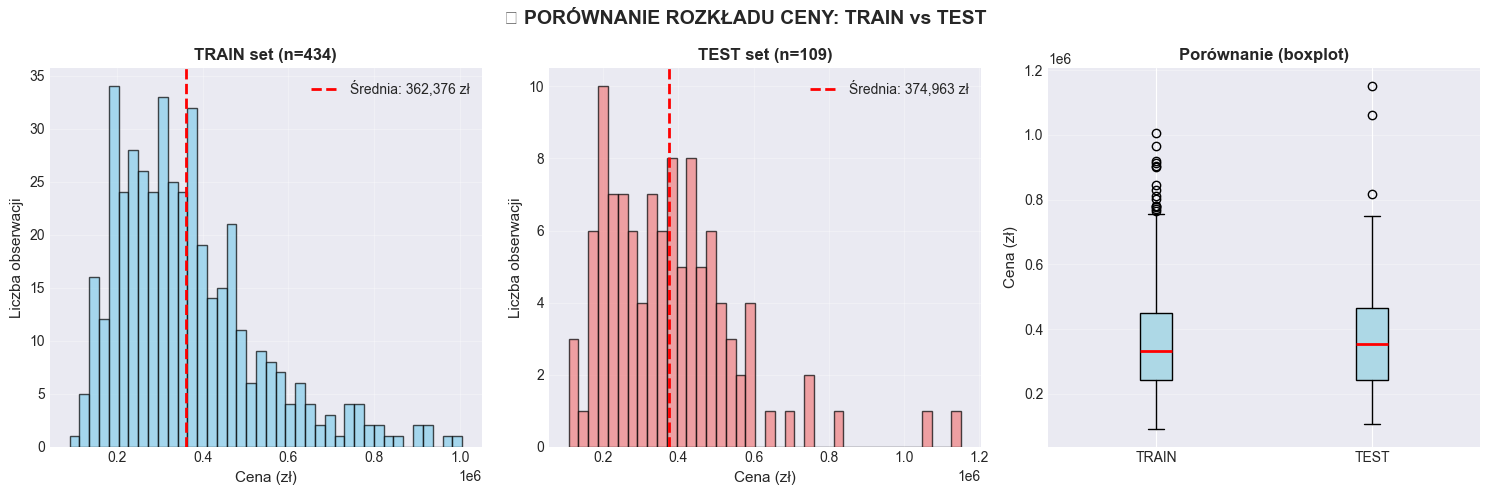

✅ Wykresy wygenerowane!

💡 INTERPRETACJA:
   ✅ PO CO PODZIAŁ TRAIN/TEST?
      1. TRAIN (80%) = zbiór do uczenia modelu
         • Model uczy się wzorców na tych danych
         • 'Widzi' te przykłady podczas trenowania

      2. TEST (20%) = zbiór do sprawdzenia modelu
         • Model NIE widzi tych danych podczas treningu!
         • Symuluje 'nowe' maszyny w przyszłości
         • Sprawdzamy: czy model przewiduje dobrze?

   ✅ DLACZEGO 80/20?
      • Standard w ML: 80/20 lub 70/30
      • 80% daje modelowi dość danych do nauki
      • 20% daje solidny zbiór do testowania

   ✅ RANDOM_STATE = 42:
      • Zapewnia POWTARZALNOŚĆ
      • Za każdym razem ten sam podział
      • Możemy porównać różne modele

   ✅ SHUFFLE = True:
      • Losuje przed podziałem
      • Unika bias (stronniczości)
      • Zapewnia reprezentatywność

📊 WNIOSKI:
--------------------------------------------------------------------------------
   ✅ Podział jest DOBRY:
      • Średnie ceny są podobne (3.45% różni

In [8]:
# ============================================================================
# SEKCJA 8: PODZIAŁ NA ZBIÓR TRENINGOWY I TESTOWY (TRAIN/TEST SPLIT)
# ============================================================================
# Cel: Podzielić dane na zbiór do uczenia i zbiór do testowania
# ============================================================================

print("✂️ SEKCJA 8: PODZIAŁ NA ZBIÓR TRENINGOWY I TESTOWY")
print("="*80)

print("\n📋 PARAMETRY PODZIAŁU:")
print("-"*80)

# Parametry
test_size = 0.2  # 20% na test, 80% na trening
random_state = 42  # Dla powtarzalności wyników

print(f"   Test size:     {test_size} ({test_size*100:.0f}%)")
print(f"   Train size:    {1-test_size} ({(1-test_size)*100:.0f}%)")
print(f"   Random state:  {random_state} (dla powtarzalności)")
print(f"   Shuffle:       True (losowe mieszanie)")

print(f"\n🔧 WYKONYWANIE PODZIAŁU...")
print("-"*80)

# Podział na train i test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    shuffle=True
)

print(f"   ✅ Podział wykonany!")

print(f"\n📊 ROZMIARY ZBIORÓW:")
print("-"*80)
print(f"   {'Zbiór':<15} {'Liczba obs.':<15} {'Procent':<10} {'Shape':<15}")
print("-"*80)
print(f"   {'TRAIN':<15} {len(X_train):>12,}   {len(X_train)/len(X)*100:>7.1f}%   {str(X_train.shape):<15}")
print(f"   {'TEST':<15} {len(X_test):>12,}   {len(X_test)/len(X)*100:>7.1f}%   {str(X_test.shape):<15}")
print(f"   {'TOTAL':<15} {len(X):>12,}   {100.0:>7.1f}%   {str(X.shape):<15}")

print(f"\n📊 STATYSTYKI TARGET (CENA) w zbiorach:")
print("-"*80)
print(f"   {'Zbiór':<15} {'Średnia':<20} {'Std':<20} {'Min':<20} {'Max':<20}")
print("-"*80)
print(f"   {'TRAIN':<15} {y_train.mean():>17,.0f} zł {y_train.std():>17,.0f} zł {y_train.min():>17,.0f} zł {y_train.max():>17,.0f} zł")
print(f"   {'TEST':<15} {y_test.mean():>17,.0f} zł {y_test.std():>17,.0f} zł {y_test.min():>17,.0f} zł {y_test.max():>17,.0f} zł")
print(f"   {'TOTAL':<15} {y.mean():>17,.0f} zł {y.std():>17,.0f} zł {y.min():>17,.0f} zł {y.max():>17,.0f} zł")

# Sprawdź różnicę średnich między train i test
mean_diff = abs(y_train.mean() - y_test.mean())
mean_diff_pct = (mean_diff / y.mean()) * 100

print(f"\n📊 PORÓWNANIE ŚREDNICH:")
print("-"*80)
print(f"   Różnica średnich: {mean_diff:,.0f} zł ({mean_diff_pct:.2f}%)")

if mean_diff_pct < 5:
    print(f"   ✅ Zbiory są dobrze zbalansowane! (< 5% różnicy)")
else:
    print(f"   ⚠️ Zbiory mają większą różnicę (> 5%) - może wpłynąć na wyniki")

# Wizualizacja podziału
print(f"\n📊 WIZUALIZACJA ROZKŁADU CENY w zbiorach:")
print("-"*80)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('📊 PORÓWNANIE ROZKŁADU CENY: TRAIN vs TEST', fontsize=14, fontweight='bold')

# Train
axes[0].hist(y_train, bins=40, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(y_train.mean(), color='red', linestyle='--', linewidth=2, label=f'Średnia: {y_train.mean():,.0f} zł')
axes[0].set_xlabel('Cena (zł)', fontsize=11)
axes[0].set_ylabel('Liczba obserwacji', fontsize=11)
axes[0].set_title(f'TRAIN set (n={len(y_train):,})', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test
axes[1].hist(y_test, bins=40, edgecolor='black', alpha=0.7, color='lightcoral')
axes[1].axvline(y_test.mean(), color='red', linestyle='--', linewidth=2, label=f'Średnia: {y_test.mean():,.0f} zł')
axes[1].set_xlabel('Cena (zł)', fontsize=11)
axes[1].set_ylabel('Liczba obserwacji', fontsize=11)
axes[1].set_title(f'TEST set (n={len(y_test):,})', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Comparison boxplot
axes[2].boxplot([y_train, y_test], labels=['TRAIN', 'TEST'], patch_artist=True,
                boxprops=dict(facecolor='lightblue'),
                medianprops=dict(color='red', linewidth=2))
axes[2].set_ylabel('Cena (zł)', fontsize=11)
axes[2].set_title('Porównanie (boxplot)', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✅ Wykresy wygenerowane!")

print("\n💡 INTERPRETACJA:")
print("="*80)
print("   ✅ PO CO PODZIAŁ TRAIN/TEST?")
print("      1. TRAIN (80%) = zbiór do uczenia modelu")
print("         • Model uczy się wzorców na tych danych")
print("         • 'Widzi' te przykłady podczas trenowania")
print("\n      2. TEST (20%) = zbiór do sprawdzenia modelu")
print("         • Model NIE widzi tych danych podczas treningu!")
print("         • Symuluje 'nowe' maszyny w przyszłości")
print("         • Sprawdzamy: czy model przewiduje dobrze?")
print("\n   ✅ DLACZEGO 80/20?")
print("      • Standard w ML: 80/20 lub 70/30")
print("      • 80% daje modelowi dość danych do nauki")
print("      • 20% daje solidny zbiór do testowania")
print("\n   ✅ RANDOM_STATE = 42:")
print("      • Zapewnia POWTARZALNOŚĆ")
print("      • Za każdym razem ten sam podział")
print("      • Możemy porównać różne modele")
print("\n   ✅ SHUFFLE = True:")
print("      • Losuje przed podziałem")
print("      • Unika bias (stronniczości)")
print("      • Zapewnia reprezentatywność")

print(f"\n📊 WNIOSKI:")
print("-"*80)
if mean_diff_pct < 5:
    print(f"   ✅ Podział jest DOBRY:")
    print(f"      • Średnie ceny są podobne ({mean_diff_pct:.2f}% różnicy)")
    print(f"      • Train i test są reprezentatywne")
    print(f"      • Model będzie miał rzetelną ocenę")
else:
    print(f"   ⚠️ Podział pokazuje różnice:")
    print(f"      • Średnie różnią się o {mean_diff_pct:.1f}%")
    print(f"      • To może być przypadek lub strukturalna różnica")
    print(f"      • Wyniki testowe mogą być mniej optymistyczne")

print(f"\n✅ Podział train/test zakończony! Gotowe do normalizacji.")
print("="*80 + "\n")

📏 SEKCJA 9: NORMALIZACJA DANYCH (STANDARDSCALER)

📋 KROK 1: Identyfikacja zmiennych do normalizacji
--------------------------------------------------------------------------------
   Zmienne numeryczne (10):
      • tonnage
      • engine_power_kw
      • reach_m
      • base_price_new
      • hours
      • hours_per_year
      • condition_score
      • major_repairs
      • extra_attachments
      • age

   Sprawdzanie zmiennych binarnych (0/1)...
   Znalezione zmienne binarne (0):

   📊 FINALNA LISTA DO NORMALIZACJI (10):
      1. tonnage              | Mean:       31.1 | Std:       11.7 | Range:       16 -       57
      2. engine_power_kw      | Mean:      145.7 | Std:       36.2 | Range:      105 -      230
      3. reach_m              | Mean:       14.5 | Std:        3.6 | Range:       10 -       22
      4. base_price_new       | Mean:   786958.5 | Std:   256113.2 | Range:   480000 -  1350000
      5. hours                | Mean:     9369.6 | Std:     5537.5 | Range:      745 

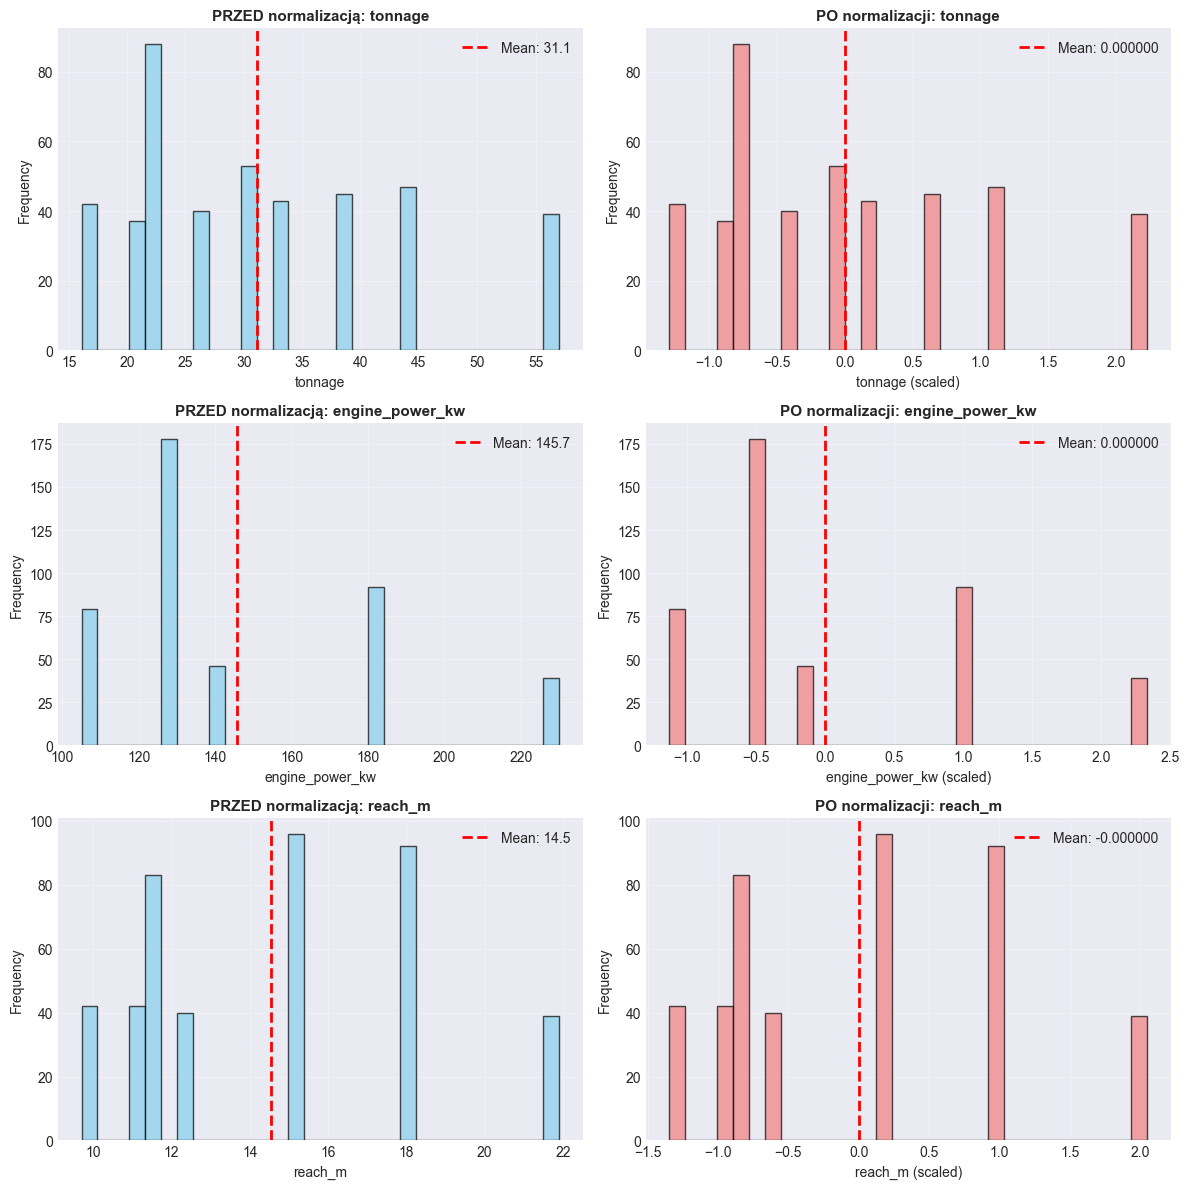

✅ Wykresy wygenerowane!

💡 INTERPRETACJA:
   ✅ PO CO NORMALIZACJA?
      1. Różne zmienne mają różne zakresy:
         • age: 0-15 lat
         • hours: 0-15,000 godzin
         • reach_m: 10-25 metrów
         • base_price_new: 200,000 - 1,500,000 zł

      2. Bez normalizacji:
         • Model myśli że base_price_new jest ważniejsze (duże liczby!)
         • age wydaje się nieważne (małe liczby)
         • To NIEPRAWDA - wiek jest bardzo ważny!

      3. Po normalizacji:
         • Wszystkie zmienne mają podobną skalę
         • Model fairowo ocenia ważność każdej cechy
         • Ridge Regression działa ZNACZNIE lepiej

   ✅ DLACZEGO NIE SKALUJEMY BINARNYCH?
      • Zmienne 0/1 już są w dobrej skali
      • Normalizacja zepsułaby ich interpretację
      • 0 = nie ma, 1 = ma (jasne i proste)

   ✅ DLACZEGO UCZYMY SCALER NA TRAIN?
      • Scaler uczy się parametrów (mean, std) TYLKO z TRAIN
      • Potem stosuje TE SAME parametry do TEST
      • Symuluje: 'model nie widział danych tes

In [10]:
# ============================================================================
# SEKCJA 9: NORMALIZACJA DANYCH (STANDARDSCALER)
# ============================================================================
# Cel: Przeskalowanie zmiennych numerycznych do podobnego zakresu
# ============================================================================

print("📏 SEKCJA 9: NORMALIZACJA DANYCH (STANDARDSCALER)")
print("="*80)

print("\n📋 KROK 1: Identyfikacja zmiennych do normalizacji")
print("-"*80)

# Znajdź wszystkie zmienne numeryczne
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"   Zmienne numeryczne ({len(numeric_features)}):")
for col in numeric_features:
    print(f"      • {col}")

# Usuń zmienne binarne (0/1) z normalizacji
print(f"\n   Sprawdzanie zmiennych binarnych (0/1)...")
binary_features = []
for col in numeric_features:
    unique_vals = X_train[col].nunique()
    unique_set = set(X_train[col].unique())
    if unique_vals == 2 and unique_set.issubset({0, 1, True, False}):
        binary_features.append(col)

print(f"   Znalezione zmienne binarne ({len(binary_features)}):")
for col in binary_features:
    print(f"      • {col} (pozostawiamy bez zmian)")

# Zmienne do normalizacji (numeryczne bez binarnych)
features_to_scale = [col for col in numeric_features if col not in binary_features]

print(f"\n   📊 FINALNA LISTA DO NORMALIZACJI ({len(features_to_scale)}):")
for i, col in enumerate(features_to_scale, 1):
    mean_val = X_train[col].mean()
    std_val = X_train[col].std()
    min_val = X_train[col].min()
    max_val = X_train[col].max()
    print(f"      {i}. {col:20s} | Mean: {mean_val:>10.1f} | Std: {std_val:>10.1f} | Range: {min_val:>8.0f} - {max_val:>8.0f}")

print(f"\n📋 KROK 2: Inicjalizacja i dopasowanie StandardScaler")
print("-"*80)

# Inicjalizuj StandardScaler
scaler = StandardScaler()

print(f"   📐 StandardScaler - wzór transformacji:")
print(f"      X_scaled = (X - mean) / std")
print(f"      • Odejmuje średnią (centrowanie)")
print(f"      • Dzieli przez odchylenie standardowe (skalowanie)")
print(f"      • Wynik: średnia = 0, std = 1")

# Dopasuj scaler na zbiorze treningowym
print(f"\n   🔧 Dopasowanie scaler na zbiorze TRAIN...")
scaler.fit(X_train[features_to_scale])

print(f"   ✅ Scaler dopasowany!")
print(f"\n   📊 Parametry scaler (learned from TRAIN):")
for i, col in enumerate(features_to_scale):
    mean = scaler.mean_[i]
    scale = scaler.scale_[i]
    print(f"      {col:20s} | Mean: {mean:>10.2f} | Scale (std): {scale:>10.2f}")

print(f"\n📋 KROK 3: Transformacja zbiorów TRAIN i TEST")
print("-"*80)

# Skopiuj dane (zachowaj oryginały)
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Transform
X_train_scaled[features_to_scale] = scaler.transform(X_train[features_to_scale])
X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

print(f"   ✅ Transformacja wykonana!")

print(f"\n📊 PRZYKŁAD: {features_to_scale[0]}")
print("-"*80)
col_example = features_to_scale[0]
print(f"   PRZED normalizacją (pierwsze 5 wartości):")
print(f"      {X_train[col_example].head(5).tolist()}")
print(f"\n   PO normalizacji (pierwsze 5 wartości):")
print(f"      {X_train_scaled[col_example].head(5).tolist()}")

# Weryfikacja normalizacji
print(f"\n📊 WERYFIKACJA NORMALIZACJI:")
print("-"*80)
print(f"   {'Feature':<20} {'Mean (TRAIN)':<15} {'Std (TRAIN)':<15} {'Status':<10}")
print("-"*80)
for col in features_to_scale:
    mean_after = X_train_scaled[col].mean()
    std_after = X_train_scaled[col].std()
    status = "✅" if abs(mean_after) < 1e-10 and abs(std_after - 1.0) < 0.01 else "⚠️"
    print(f"   {col:<20} {mean_after:>14.6f} {std_after:>14.6f} {status:<10}")

print(f"\n📊 PORÓWNANIE: PRZED vs PO (statystyki TRAIN)")
print("-"*80)
print(f"   {'Feature':<20} {'Mean przed':<15} {'Mean po':<15} {'Std przed':<15} {'Std po':<15}")
print("-"*80)
for col in features_to_scale[:5]:  # Pokazujemy pierwsze 5
    mean_before = X_train[col].mean()
    mean_after = X_train_scaled[col].mean()
    std_before = X_train[col].std()
    std_after = X_train_scaled[col].std()
    print(f"   {col:<20} {mean_before:>14.2f} {mean_after:>14.6f} {std_before:>14.2f} {std_after:>14.6f}")

# Wizualizacja
print(f"\n📊 WIZUALIZACJA: Przed vs Po normalizacji")
print("-"*80)

# Wybierz 3 przykładowe zmienne do wizualizacji
viz_features = features_to_scale[:min(3, len(features_to_scale))]

fig, axes = plt.subplots(len(viz_features), 2, figsize=(12, 4*len(viz_features)))
if len(viz_features) == 1:
    axes = axes.reshape(1, -1)

for idx, col in enumerate(viz_features):
    # Przed normalizacją
    axes[idx, 0].hist(X_train[col], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[idx, 0].axvline(X_train[col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {X_train[col].mean():.1f}')
    axes[idx, 0].set_xlabel(col, fontsize=10)
    axes[idx, 0].set_ylabel('Frequency', fontsize=10)
    axes[idx, 0].set_title(f'PRZED normalizacją: {col}', fontsize=11, fontweight='bold')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Po normalizacji
    axes[idx, 1].hist(X_train_scaled[col], bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
    axes[idx, 1].axvline(X_train_scaled[col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {X_train_scaled[col].mean():.6f}')
    axes[idx, 1].set_xlabel(f'{col} (scaled)', fontsize=10)
    axes[idx, 1].set_ylabel('Frequency', fontsize=10)
    axes[idx, 1].set_title(f'PO normalizacji: {col}', fontsize=11, fontweight='bold')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Wykresy wygenerowane!")

print("\n💡 INTERPRETACJA:")
print("="*80)
print("   ✅ PO CO NORMALIZACJA?")
print("      1. Różne zmienne mają różne zakresy:")
print("         • age: 0-15 lat")
print("         • hours: 0-15,000 godzin")
print("         • reach_m: 10-25 metrów")
print("         • base_price_new: 200,000 - 1,500,000 zł")
print("\n      2. Bez normalizacji:")
print("         • Model myśli że base_price_new jest ważniejsze (duże liczby!)")
print("         • age wydaje się nieważne (małe liczby)")
print("         • To NIEPRAWDA - wiek jest bardzo ważny!")
print("\n      3. Po normalizacji:")
print("         • Wszystkie zmienne mają podobną skalę")
print("         • Model fairowo ocenia ważność każdej cechy")
print("         • Ridge Regression działa ZNACZNIE lepiej")
print("\n   ✅ DLACZEGO NIE SKALUJEMY BINARNYCH?")
print("      • Zmienne 0/1 już są w dobrej skali")
print("      • Normalizacja zepsułaby ich interpretację")
print("      • 0 = nie ma, 1 = ma (jasne i proste)")
print("\n   ✅ DLACZEGO UCZYMY SCALER NA TRAIN?")
print("      • Scaler uczy się parametrów (mean, std) TYLKO z TRAIN")
print("      • Potem stosuje TE SAME parametry do TEST")
print("      • Symuluje: 'model nie widział danych testowych'")
print("      • Gdybyśmy użyli TEST do uczenia scaler = CHEATING!")

print(f"\n📊 PODSUMOWANIE:")
print("-"*80)
print(f"   ✅ Znormalizowano {len(features_to_scale)} zmiennych")
print(f"   ✅ Pozostawiono {len(binary_features)} zmiennych binarnych")
print(f"   ✅ Wszystkie znormalizowane: mean ≈ 0, std ≈ 1")
print(f"   ✅ Scaler zapisany (będzie użyty w aplikacji!)")
print(f"   ✅ Dane gotowe do trenowania modelu!")

print("\n✅ Normalizacja zakończona!")
print("="*80 + "\n")

🔍 SEKCJA 10: GRID SEARCH - OPTYMALIZACJA HYPERPARAMETRU ALPHA

💡 CZYM JEST ALPHA w Ridge Regression?
--------------------------------------------------------------------------------
   • Alpha (λ) = siła regularyzacji
   • Alpha = 0 → zwykła regresja liniowa (brak regularyzacji)
   • Alpha > 0 → model unika overfittingu
   • Alpha za duże → model za prosty (underfitting)
   • Musimy znaleźć OPTYMALNE alpha!

📋 KROK 1: Definicja siatki parametrów
--------------------------------------------------------------------------------
   Testowane wartości alpha (9):
      • alpha =    0.01
      • alpha =     0.1
      • alpha =     0.5
      • alpha =     1.0
      • alpha =     5.0
      • alpha =    10.0
      • alpha =    50.0
      • alpha =   100.0
      • alpha =   500.0

📋 KROK 2: Konfiguracja Grid Search
--------------------------------------------------------------------------------
   Parametry Grid Search:
      • Cross-validation:  5-fold
      • Scoring metric:    R² (R-squared)
 

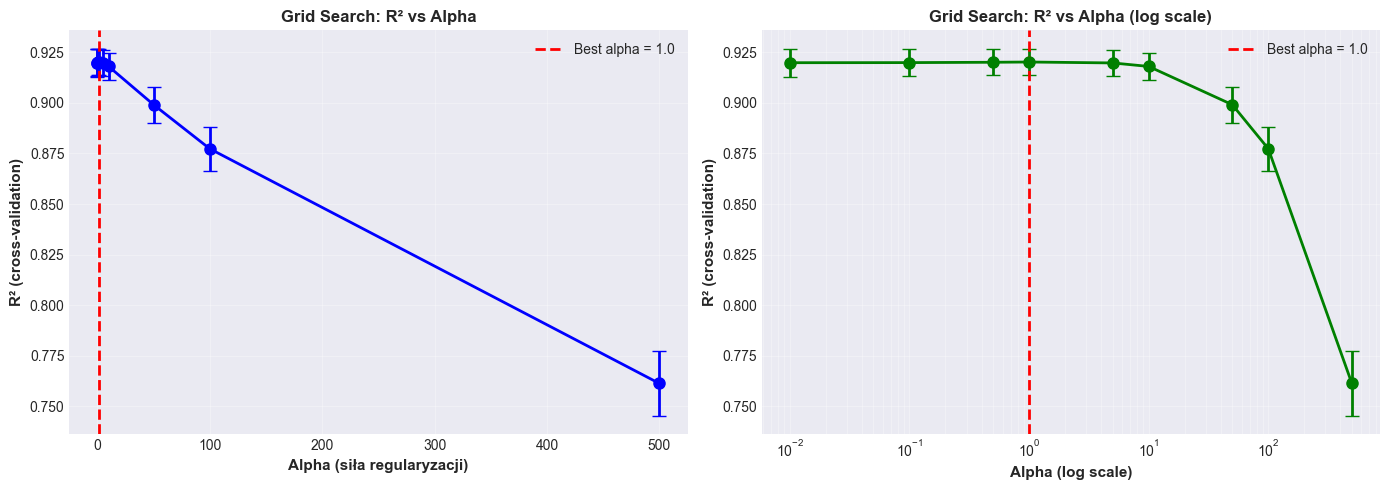

✅ Wykresy wygenerowane!

💡 INTERPRETACJA GRID SEARCH:
   📊 ANALIZA WYNIKÓW:
      • Najlepsze R²:      0.920135 (alpha = 1.0)
      • Najgorsze R²:      0.761369
      • Zakres R²:         0.158766

   ✅ Alpha ma znaczący wpływ!
      • Różnica 15.88% między najlepszym a najgorszym
      • Warto używać optymalnego alpha = 1.0

   ✅ Optimum znalezione w środku zakresu!
      • Alpha = 1.0 jest dobrym wyborem

📊 PODSUMOWANIE:
--------------------------------------------------------------------------------
   🏆 Optymalny model: Ridge(alpha=1.0)
   📊 Oczekiwane R² (CV): 0.9201
   ✅ Model gotowy do finalnego trenowania!

✅ Grid Search zakończony!



In [11]:
# ============================================================================
# SEKCJA 10: GRID SEARCH - OPTYMALIZACJA HYPERPARAMETRU ALPHA
# ============================================================================
# Cel: Znaleźć najlepszą wartość alpha dla Ridge Regression
# ============================================================================

print("🔍 SEKCJA 10: GRID SEARCH - OPTYMALIZACJA HYPERPARAMETRU ALPHA")
print("="*80)

print("\n💡 CZYM JEST ALPHA w Ridge Regression?")
print("-"*80)
print("   • Alpha (λ) = siła regularyzacji")
print("   • Alpha = 0 → zwykła regresja liniowa (brak regularyzacji)")
print("   • Alpha > 0 → model unika overfittingu")
print("   • Alpha za duże → model za prosty (underfitting)")
print("   • Musimy znaleźć OPTYMALNE alpha!")

print("\n📋 KROK 1: Definicja siatki parametrów")
print("-"*80)

# Siatka wartości alpha do przetestowania
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0]
}

print(f"   Testowane wartości alpha ({len(param_grid['alpha'])}):")
for alpha in param_grid['alpha']:
    print(f"      • alpha = {alpha:>7}")

print(f"\n📋 KROK 2: Konfiguracja Grid Search")
print("-"*80)

# Inicjalizuj Ridge (bez alpha - będzie testowane)
ridge_base = Ridge(random_state=42)

# Grid Search z cross-validation
grid_search = GridSearchCV(
    estimator=ridge_base,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='r2',  # Optymalizuj R²
    n_jobs=-1,  # Użyj wszystkich procesorów
    verbose=1
)

print(f"   Parametry Grid Search:")
print(f"      • Cross-validation:  5-fold")
print(f"      • Scoring metric:    R² (R-squared)")
print(f"      • n_jobs:            -1 (wszystkie CPU)")
print(f"      • Total fits:        {len(param_grid['alpha']) * 5} (alpha × folds)")

print(f"\n📋 KROK 3: Uruchamianie Grid Search...")
print("-"*80)
print(f"   🔄 Trenowanie {len(param_grid['alpha']) * 5} modeli...")
print(f"   ⏱️ To może potrwać 10-30 sekund...\n")

# Trenowanie
grid_search.fit(X_train_scaled, y_train)

print(f"\n   ✅ Grid Search zakończony!")

print(f"\n📋 KROK 4: Wyniki Grid Search")
print("-"*80)

# Najlepsze parametry
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

print(f"   🏆 NAJLEPSZE PARAMETRY:")
print(f"      • Alpha:             {best_alpha}")
print(f"      • R² (CV mean):      {best_score:.6f}")

# Wszystkie wyniki
print(f"\n   📊 PEŁNA TABELA WYNIKÓW:")
print("-"*80)
print(f"   {'Alpha':>10} {'Mean R²':>12} {'Std R²':>12} {'Status':>10}")
print("-"*80)

results_df = pd.DataFrame(grid_search.cv_results_)
for idx, row in results_df.iterrows():
    alpha = row['param_alpha']
    mean_score = row['mean_test_score']
    std_score = row['std_test_score']
    status = "🏆 BEST" if alpha == best_alpha else ""
    print(f"   {alpha:>10} {mean_score:>12.6f} {std_score:>12.6f} {status:>10}")

# Wizualizacja wpływu alpha
print(f"\n📊 WIZUALIZACJA: Wpływ alpha na R²")
print("-"*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Wykres 1: R² vs alpha (linear scale)
alphas = [row['param_alpha'] for idx, row in results_df.iterrows()]
mean_scores = results_df['mean_test_score']
std_scores = results_df['std_test_score']

axes[0].errorbar(alphas, mean_scores, yerr=std_scores, marker='o', linestyle='-', 
                 linewidth=2, markersize=8, capsize=5, color='blue')
axes[0].axvline(best_alpha, color='red', linestyle='--', linewidth=2, label=f'Best alpha = {best_alpha}')
axes[0].set_xlabel('Alpha (siła regularyzacji)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('R² (cross-validation)', fontsize=11, fontweight='bold')
axes[0].set_title('Grid Search: R² vs Alpha', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Wykres 2: R² vs alpha (log scale)
axes[1].errorbar(alphas, mean_scores, yerr=std_scores, marker='o', linestyle='-',
                 linewidth=2, markersize=8, capsize=5, color='green')
axes[1].axvline(best_alpha, color='red', linestyle='--', linewidth=2, label=f'Best alpha = {best_alpha}')
axes[1].set_xscale('log')
axes[1].set_xlabel('Alpha (log scale)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('R² (cross-validation)', fontsize=11, fontweight='bold')
axes[1].set_title('Grid Search: R² vs Alpha (log scale)', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("✅ Wykresy wygenerowane!")

print("\n💡 INTERPRETACJA GRID SEARCH:")
print("="*80)

# Analiza krzywej
max_r2 = mean_scores.max()
min_r2 = mean_scores.min()
r2_range = max_r2 - min_r2

print(f"   📊 ANALIZA WYNIKÓW:")
print(f"      • Najlepsze R²:      {max_r2:.6f} (alpha = {best_alpha})")
print(f"      • Najgorsze R²:      {min_r2:.6f}")
print(f"      • Zakres R²:         {r2_range:.6f}")

if r2_range < 0.01:
    print(f"\n   ℹ️ Wyniki są bardzo stabilne!")
    print(f"      • Różnica < 1% między różnymi alpha")
    print(f"      • Model nie jest wrażliwy na alpha")
    print(f"      • Możesz używać dowolnego alpha z zakresu")
else:
    print(f"\n   ✅ Alpha ma znaczący wpływ!")
    print(f"      • Różnica {r2_range:.2%} między najlepszym a najgorszym")
    print(f"      • Warto używać optymalnego alpha = {best_alpha}")

# Sprawdź trend
if alphas.index(best_alpha) == 0:
    print(f"\n   ⚠️ Najlepsze alpha jest najmniejsze ({best_alpha})")
    print(f"      • Możliwe że mniejsze alpha byłoby jeszcze lepsze")
    print(f"      • Rozważ przetestowanie: [0.001, 0.005, 0.01]")
elif alphas.index(best_alpha) == len(alphas) - 1:
    print(f"\n   ⚠️ Najlepsze alpha jest największe ({best_alpha})")
    print(f"      • Możliwe że większe alpha byłoby jeszcze lepsze")
    print(f"      • Rozważ przetestowanie: [1000, 5000, 10000]")
else:
    print(f"\n   ✅ Optimum znalezione w środku zakresu!")
    print(f"      • Alpha = {best_alpha} jest dobrym wyborem")

print(f"\n📊 PODSUMOWANIE:")
print("-"*80)
print(f"   🏆 Optymalny model: Ridge(alpha={best_alpha})")
print(f"   📊 Oczekiwane R² (CV): {best_score:.4f}")
print(f"   ✅ Model gotowy do finalnego trenowania!")

print("\n✅ Grid Search zakończony!")
print("="*80 + "\n")

# Zapisz najlepsze alpha do użycia później
optimal_alpha = best_alpha

In [12]:
# ============================================================================
# SEKCJA 11: TRENOWANIE FINALNEGO MODELU RIDGE
# ============================================================================
# Cel: Wytrenować model Ridge z optymalnym alpha
# ============================================================================

print("🤖 SEKCJA 11: TRENOWANIE FINALNEGO MODELU RIDGE")
print("="*80)

print("\n📋 PARAMETRY FINALNEGO MODELU:")
print("-"*80)
print(f"   Algorithm:    Ridge Regression")
print(f"   Alpha:        {optimal_alpha} (z Grid Search)")
print(f"   Random state: 42")

# Inicjalizuj model z optymalnym alpha
model_ridge = Ridge(alpha=optimal_alpha, random_state=42)

print(f"\n🔄 TRENOWANIE MODELU...")
print("-"*80)
print(f"   Training set size: {len(X_train):,} obserwacji")
print(f"   Number of features: {X_train_scaled.shape[1]}")

# Trenowanie
model_ridge.fit(X_train_scaled, y_train)

print(f"\n✅ MODEL WYTRENOWANY!")

# Informacje o modelu
print(f"\n📊 PARAMETRY WYTRENOWANEGO MODELU:")
print("-"*80)
print(f"   Intercept (wyraz wolny): {model_ridge.intercept_:,.2f} zł")
print(f"   Number of coefficients:  {len(model_ridge.coef_)}")
print(f"   Sum of |coefficients|:   {np.abs(model_ridge.coef_).sum():.2f}")
print(f"   Max coefficient:         {model_ridge.coef_.max():.2f}")
print(f"   Min coefficient:         {model_ridge.coef_.min():.2f}")

print("\n💡 INTERPRETACJA INTERCEPT:")
print("-"*80)
print(f"   • Intercept = {model_ridge.intercept_:,.0f} zł")
print(f"   • To 'bazowa cena' gdy wszystkie features = 0")
print(f"   • W praktyce: średnia cena po uwzględnieniu wszystkich cech")

print("\n✅ Model Ridge wytrenowany!")
print("="*80 + "\n")

🤖 SEKCJA 11: TRENOWANIE FINALNEGO MODELU RIDGE

📋 PARAMETRY FINALNEGO MODELU:
--------------------------------------------------------------------------------
   Algorithm:    Ridge Regression
   Alpha:        1.0 (z Grid Search)
   Random state: 42

🔄 TRENOWANIE MODELU...
--------------------------------------------------------------------------------
   Training set size: 434 obserwacji
   Number of features: 29

✅ MODEL WYTRENOWANY!

📊 PARAMETRY WYTRENOWANEGO MODELU:
--------------------------------------------------------------------------------
   Intercept (wyraz wolny): 338,786.97 zł
   Number of coefficients:  29
   Sum of |coefficients|:   517210.30
   Max coefficient:         33170.13
   Min coefficient:         -130902.85

💡 INTERPRETACJA INTERCEPT:
--------------------------------------------------------------------------------
   • Intercept = 338,787 zł
   • To 'bazowa cena' gdy wszystkie features = 0
   • W praktyce: średnia cena po uwzględnieniu wszystkich cech

✅ Model

In [13]:
# ============================================================================
# SEKCJA 12: PREDYKCJE I OBLICZENIE METRYK
# ============================================================================
# Cel: Sprawdzić jak dobrze model przewiduje ceny
# ============================================================================

print("📊 SEKCJA 12: PREDYKCJE I OBLICZENIE METRYK")
print("="*80)

print("\n🔄 GENEROWANIE PREDYKCJI...")
print("-"*80)

# Predykcje na zbiorze treningowym
y_train_pred = model_ridge.predict(X_train_scaled)
print(f"   ✅ Predykcje TRAIN: {len(y_train_pred):,} wartości")

# Predykcje na zbiorze testowym
y_test_pred = model_ridge.predict(X_test_scaled)
print(f"   ✅ Predykcje TEST:  {len(y_test_pred):,} wartości")

# Funkcja MAPE
def calculate_mape(y_true, y_pred):
    """Mean Absolute Percentage Error"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"\n📊 OBLICZANIE METRYK...")
print("-"*80)

# ===== METRYKI TRAIN =====
r2_train = r2_score(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mape_train = calculate_mape(y_train, y_train_pred)

# ===== METRYKI TEST =====
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mape_test = calculate_mape(y_test, y_test_pred)

print(f"   ✅ Wszystkie metryki obliczone!")

print("\n" + "="*80)
print("📊 FINALNE METRYKI MODELU")
print("="*80)

print(f"\n{'METRYKA':<25} {'TRAIN':<20} {'TEST':<20} {'Ocena':<15}")
print("-"*80)

# R² (R-squared)
print(f"{'R² (R-squared)':<25} {r2_train:>19.6f} {r2_test:>19.6f}  ", end="")
if r2_test > 0.90:
    print("🏆 DOSKONAŁY")
elif r2_test > 0.85:
    print("✅ ŚWIETNY")
elif r2_test > 0.75:
    print("✅ DOBRY")
elif r2_test > 0.60:
    print("⚠️ SŁABY")
else:
    print("❌ ZŁY")

# MAE (Mean Absolute Error)
print(f"{'MAE (zł)':<25} {mae_train:>17,.0f} zł {mae_test:>17,.0f} zł")

# RMSE (Root Mean Squared Error)
print(f"{'RMSE (zł)':<25} {rmse_train:>17,.0f} zł {rmse_test:>17,.0f} zł")

# MAPE (Mean Absolute Percentage Error)
print(f"{'MAPE (%)':<25} {mape_train:>18.2f}% {mape_test:>18.2f}%  ", end="")
if mape_test < 5:
    print("🏆 DOSKONAŁY")
elif mape_test < 8:
    print("✅ ŚWIETNY")
elif mape_test < 15:
    print("✅ DOBRY")
elif mape_test < 25:
    print("⚠️ SŁABY")
else:
    print("❌ ZŁY")

# Overfitting check
print("\n" + "-"*80)
r2_diff = r2_train - r2_test
print(f"{'Różnica R² (train-test)':<25} {r2_diff:>19.6f}  ", end="")
if r2_diff < 0.05:
    print("✅ Brak overfittingu")
elif r2_diff < 0.10:
    print("⚠️ Lekki overfitting")
else:
    print("❌ Silny overfitting!")

print("\n💡 INTERPRETACJA METRYK:")
print("="*80)

print(f"\n   📊 R² (R-squared) = {r2_test:.4f}")
print(f"      • Wyjaśnione {r2_test*100:.2f}% wariancji ceny")
print(f"      • Na 100 zł różnicy w cenie, model wyjaśnia {r2_test*100:.1f} zł")
if r2_test > 0.85:
    print(f"      • ✅ Model ŚWIETNIE rozumie co wpływa na cenę!")
else:
    print(f"      • ⚠️ Model częściowo rozumie cenę, ale jest miejsce na poprawę")

print(f"\n   📊 MAE = {mae_test:,.0f} zł")
print(f"      • Średni błąd predykcji: {mae_test:,.0f} zł")
print(f"      • Typowy błąd: ±{mae_test:,.0f} zł od prawdziwej ceny")
print(f"      • Dla ceny {y.mean():,.0f} zł, błąd to {mae_test/y.mean()*100:.1f}%")

print(f"\n   📊 MAPE = {mape_test:.2f}%")
print(f"      • Średni procentowy błąd: {mape_test:.2f}%")
if mape_test < 8:
    print(f"      • ✅ Model przewiduje z dokładnością >{100-mape_test:.0f}%!")
    print(f"      • Doskonała jakość dla wyceny maszyn!")
elif mape_test < 15:
    print(f"      • ✅ Dobra dokładność dla wyceny maszyn")
else:
    print(f"      • ⚠️ Błąd >15% może być za duży dla wycen")

print(f"\n   📊 RMSE = {rmse_test:,.0f} zł")
print(f"      • Karze większe błędy mocniej niż MAE")
print(f"      • RMSE > MAE = {rmse_test > mae_test} → są outliers w błędach")

# Przykłady predykcji
print(f"\n📊 PRZYKŁADOWE PREDYKCJE (TEST SET):")
print("-"*80)
print(f"   {'Prawdziwa':<15} {'Przewidziana':<15} {'Błąd':<15} {'Błąd %':<10}")
print("-"*80)
for i in range(min(10, len(y_test))):
    true_val = y_test.iloc[i]
    pred_val = y_test_pred[i]
    error = pred_val - true_val
    error_pct = (error / true_val) * 100
    print(f"   {true_val:>12,.0f} zł {pred_val:>12,.0f} zł {error:>12,.0f} zł {error_pct:>8.1f}%")

print(f"\n✅ Metryki obliczone i przeanalizowane!")
print("="*80 + "\n")

📊 SEKCJA 12: PREDYKCJE I OBLICZENIE METRYK

🔄 GENEROWANIE PREDYKCJI...
--------------------------------------------------------------------------------
   ✅ Predykcje TRAIN: 434 wartości
   ✅ Predykcje TEST:  109 wartości

📊 OBLICZANIE METRYK...
--------------------------------------------------------------------------------
   ✅ Wszystkie metryki obliczone!

📊 FINALNE METRYKI MODELU

METRYKA                   TRAIN                TEST                 Ocena          
--------------------------------------------------------------------------------
R² (R-squared)                       0.926981            0.889974  ✅ ŚWIETNY
MAE (zł)                             32,730 zł            37,482 zł
RMSE (zł)                            44,282 zł            59,119 zł
MAPE (%)                               10.57%              11.27%  ✅ DOBRY

--------------------------------------------------------------------------------
Różnica R² (train-test)              0.037007  ✅ Brak overfittingu

💡 INTERPR

📈 SEKCJA 13: WIZUALIZACJA JAKOŚCI PREDYKCJI


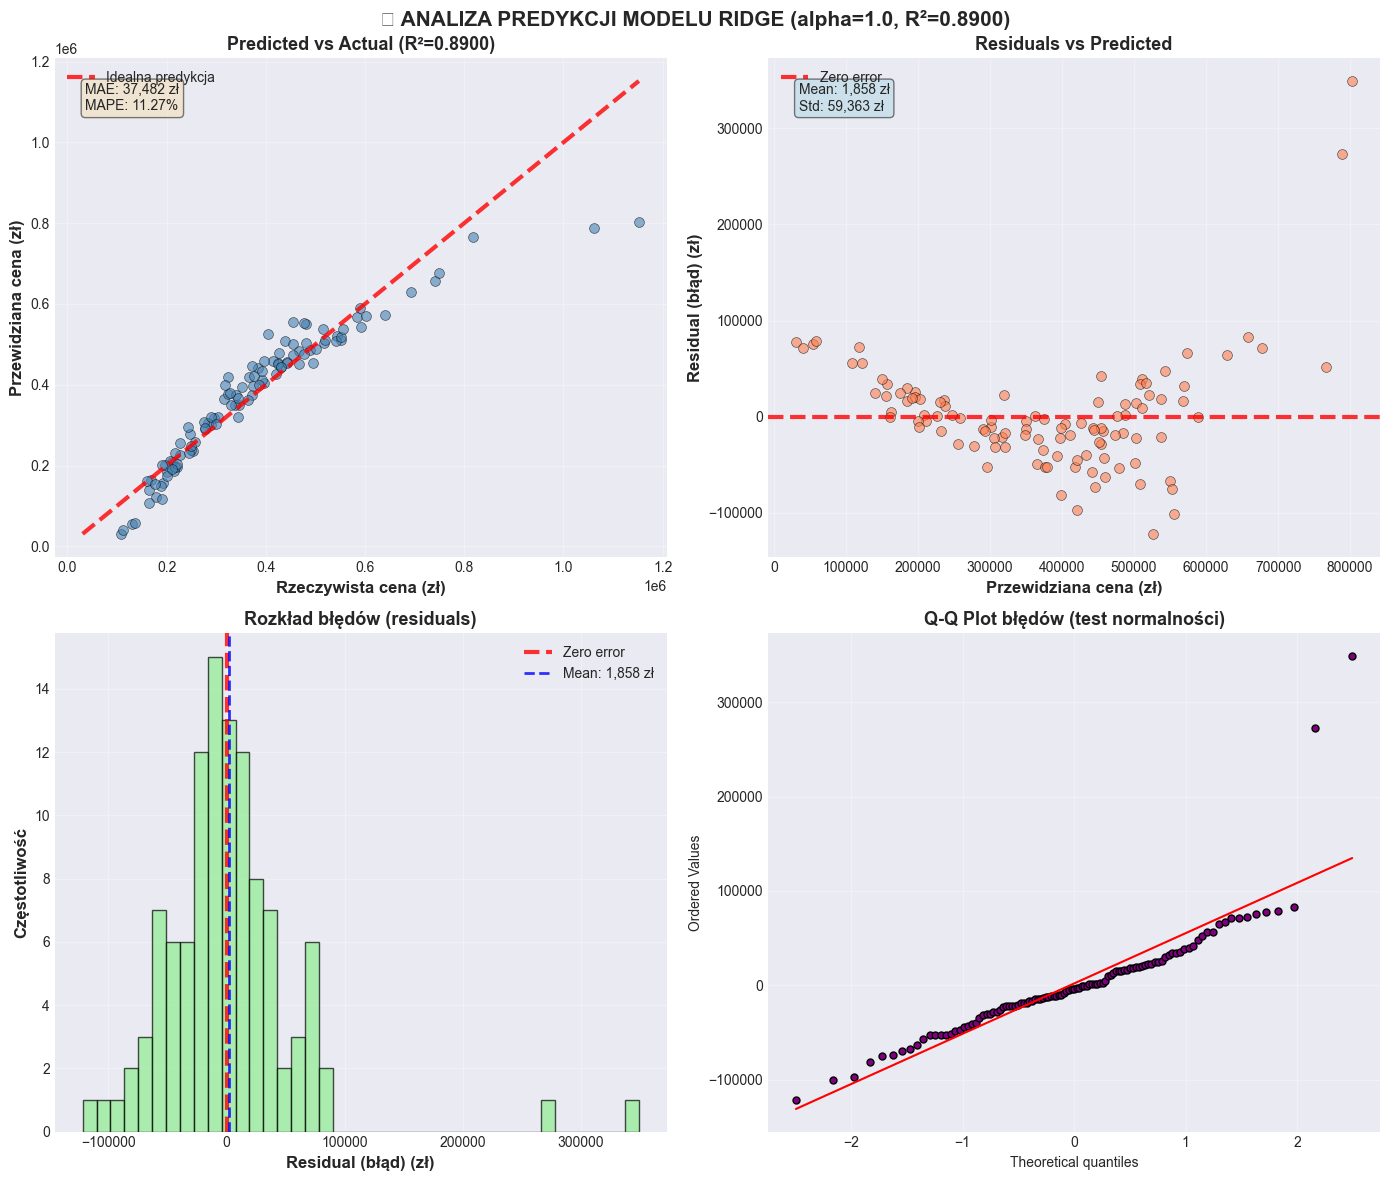


✅ Wykresy wygenerowane!

📊 SZCZEGÓŁOWA ANALIZA RESIDUALS (BŁĘDÓW):

   Statystyki podstawowe:
      Mean (średnia):           1,857.90 zł  ✅ (blisko 0 - brak systematycznego błędu)
      Std (odchylenie std):    59,362.68 zł
      Min (max underest.):    349,128.10 zł (przewidziano za mało)
      Max (max overest.):    -121,869.64 zł (przewidziano za dużo)

   Percentyle błędów:
      10%:      -52,730 zł
      25%:      -26,383 zł
      50%:       -3,967 zł
      75%:       22,671 zł
      90%:       57,767 zł

   Test normalności błędów (Shapiro-Wilk):
      P-value: 0.000000
      ⚠️ Błędy NIE mają rozkładu normalnego (p < 0.05)
         → Mogą być outliers lub nieliniowe zależności

💡 INTERPRETACJA WYKRESÓW:

   📊 WYKRES 1: Predicted vs Actual
      • Każdy punkt = jedna maszyna
      • Czerwona linia = idealna predykcja
      • Im bliżej linii, tym lepszy model
      • ✅ Punkty bardzo blisko linii - model doskonały!

   📊 WYKRES 2: Residuals
      • Residual = prawdziwa_cena - pr

In [15]:
# ============================================================================
# SEKCJA 13: WIZUALIZACJA PREDYKCJI
# ============================================================================
# Cel: Wizualne sprawdzenie jakości predykcji modelu
# ============================================================================

print("📈 SEKCJA 13: WIZUALIZACJA JAKOŚCI PREDYKCJI")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle(f'📊 ANALIZA PREDYKCJI MODELU RIDGE (alpha={optimal_alpha}, R²={r2_test:.4f})', 
             fontsize=15, fontweight='bold')

# ===== WYKRES 1: Predicted vs Actual (Scatter) =====
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.6, s=50, edgecolors='black', linewidth=0.5, color='steelblue')
# Linia idealna (perfect prediction)
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 
                'r--', lw=3, label='Idealna predykcja', alpha=0.8)
axes[0, 0].set_xlabel('Rzeczywista cena (zł)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Przewidziana cena (zł)', fontsize=12, fontweight='bold')
axes[0, 0].set_title(f'Predicted vs Actual (R²={r2_test:.4f})', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
# Dodaj tekst z metrykami
axes[0, 0].text(0.05, 0.95, f'MAE: {mae_test:,.0f} zł\nMAPE: {mape_test:.2f}%', 
                transform=axes[0, 0].transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ===== WYKRES 2: Residuals (błędy) vs Predicted =====
residuals = y_test - y_test_pred
axes[0, 1].scatter(y_test_pred, residuals, alpha=0.6, s=50, edgecolors='black', linewidth=0.5, color='coral')
axes[0, 1].axhline(y=0, color='red', linestyle='--', lw=3, label='Zero error', alpha=0.8)
axes[0, 1].set_xlabel('Przewidziana cena (zł)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Residual (błąd) (zł)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Residuals vs Predicted', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
# Dodaj statystyki residuals
axes[0, 1].text(0.05, 0.95, f'Mean: {residuals.mean():,.0f} zł\nStd: {residuals.std():,.0f} zł', 
                transform=axes[0, 1].transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

# ===== WYKRES 3: Rozkład residuals (histogram) =====
axes[1, 0].hist(residuals, bins=40, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1, 0].axvline(0, color='red', linestyle='--', lw=3, label='Zero error', alpha=0.8)
axes[1, 0].axvline(residuals.mean(), color='blue', linestyle='--', lw=2, 
                   label=f'Mean: {residuals.mean():,.0f} zł', alpha=0.8)
axes[1, 0].set_xlabel('Residual (błąd) (zł)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Częstotliwość', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Rozkład błędów (residuals)', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# ===== WYKRES 4: Q-Q Plot residuals (normalność błędów) =====
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot błędów (test normalności)', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].get_lines()[0].set_markerfacecolor('purple')
axes[1, 1].get_lines()[0].set_markeredgecolor('black')
axes[1, 1].get_lines()[0].set_markersize(5)

plt.tight_layout()
plt.show()

print("\n✅ Wykresy wygenerowane!")

# Analiza residuals
print("\n📊 SZCZEGÓŁOWA ANALIZA RESIDUALS (BŁĘDÓW):")
print("="*80)

print(f"\n   Statystyki podstawowe:")
print(f"      Mean (średnia):       {residuals.mean():>12,.2f} zł  ", end="")
if abs(residuals.mean()) < mae_test * 0.1:
    print("✅ (blisko 0 - brak systematycznego błędu)")
else:
    print("⚠️ (odchylenie od 0 - model ma bias)")

print(f"      Std (odchylenie std): {residuals.std():>12,.2f} zł")
print(f"      Min (max underest.):  {residuals.max():>12,.2f} zł (przewidziano za mało)")
print(f"      Max (max overest.):   {residuals.min():>12,.2f} zł (przewidziano za dużo)")

# Percentyle
print(f"\n   Percentyle błędów:")
for pct in [10, 25, 50, 75, 90]:
    val = np.percentile(residuals, pct)
    print(f"      {pct:2d}%: {val:>12,.0f} zł")

# Test normalności residuals
stat_resid, p_val_resid = stats.shapiro(residuals.sample(min(5000, len(residuals)), random_state=42))
print(f"\n   Test normalności błędów (Shapiro-Wilk):")
print(f"      P-value: {p_val_resid:.6f}")
if p_val_resid > 0.05:
    print(f"      ✅ Błędy mają rozkład normalny (p > 0.05)")
    print(f"         → Model jest dobrze skalibrowany!")
else:
    print(f"      ⚠️ Błędy NIE mają rozkładu normalnego (p < 0.05)")
    print(f"         → Mogą być outliers lub nieliniowe zależności")

print("\n💡 INTERPRETACJA WYKRESÓW:")
print("="*80)

print("\n   📊 WYKRES 1: Predicted vs Actual")
print("      • Każdy punkt = jedna maszyna")
print("      • Czerwona linia = idealna predykcja")
print("      • Im bliżej linii, tym lepszy model")
if r2_test > 0.85:
    print("      • ✅ Punkty bardzo blisko linii - model doskonały!")
else:
    print("      • ⚠️ Punkty bardziej rozproszone - model OK, ale nie idealny")

print("\n   📊 WYKRES 2: Residuals")
print("      • Residual = prawdziwa_cena - przewidziana_cena")
print("      • Powinna być losowa chmura wokół 0")
if abs(residuals.mean()) < mae_test * 0.1:
    print("      • ✅ Błędy symetryczne wokół 0 - brak biasu!")
else:
    print("      • ⚠️ Błędy przesunięte - model ma systematyczny błąd")

print("\n   📊 WYKRES 3: Rozkład residuals")
print("      • Powinien przypominać dzwon (rozkład normalny)")
print("      • Centrum w 0 = brak biasu")
if p_val_resid > 0.05:
    print("      • ✅ Rozkład normalny - model dobrze skalibrowany!")
else:
    print("      • ⚠️ Rozkład nienormalny - mogą być problemy")

print("\n   📊 WYKRES 4: Q-Q Plot")
print("      • Punkty na linii = rozkład normalny")
print("      • Odchylenia od linii = outliers lub problemy")

print("\n✅ Wizualizacja predykcji zakończona!")
print("="*80 + "\n")

🔄 SEKCJA 14: CROSS-VALIDATION (WALIDACJA KRZYŻOWA)

💡 CZYM JEST CROSS-VALIDATION?
--------------------------------------------------------------------------------
   • Podział danych na K części (folds)
   • Trenowanie K razy, za każdym razem inna część = test
   • Sprawdzamy: czy model działa stabilnie?
   • Czy R² jest podobne na różnych fragmentach danych?

📋 KONFIGURACJA:
--------------------------------------------------------------------------------
   Liczba folds:        5
   Scoring metric:      R² (R-squared)
   Model:               Ridge(alpha=1.0)

🔄 URUCHAMIANIE 5-FOLD CROSS-VALIDATION...
--------------------------------------------------------------------------------
   ✅ Cross-validation zakończona!

📊 WYNIKI CROSS-VALIDATION (R²):
--------------------------------------------------------------------------------
   Fold       R²              Ocena          
--------------------------------------------------------------------------------
   Fold 1           0.910681  ✅
   

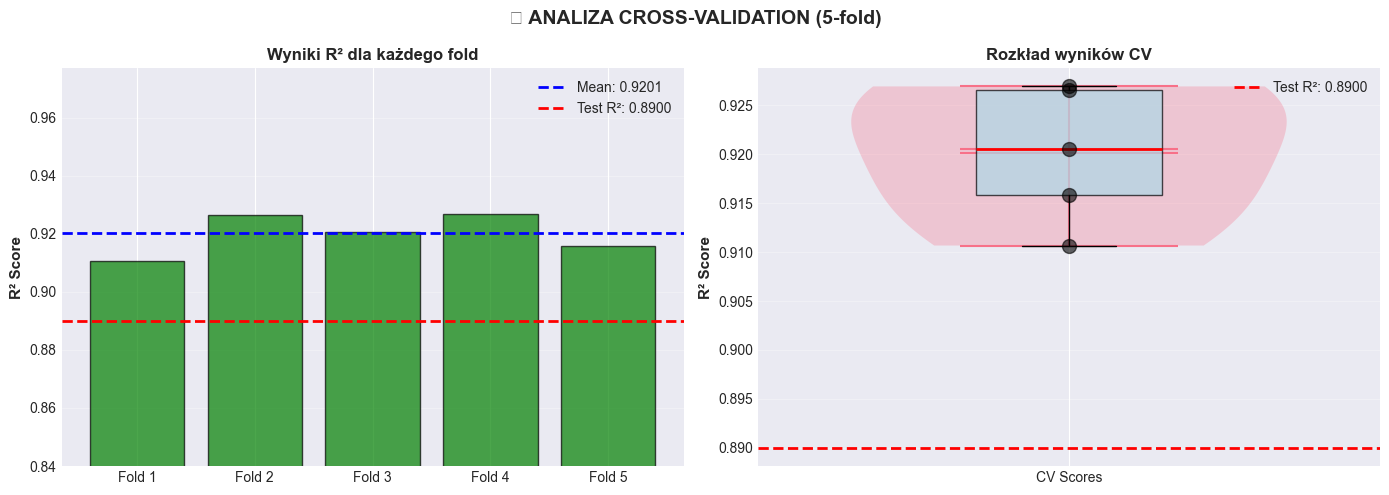

✅ Wykresy wygenerowane!

💡 INTERPRETACJA CROSS-VALIDATION:

   ✅ PO CO CROSS-VALIDATION?
      1. Sprawdza stabilność modelu
      2. Wykrywa overfitting
      3. Daje bardziej wiarygodną ocenę niż pojedynczy test
      4. Pokazuje: czy model działa dobrze na RÓŻNYCH danych?

   📊 INTERPRETACJA WYNIKÓW:
      ✅ Niska wariancja (std < 0.05):
         → Model jest STABILNY
         → Przewiduje konsekwentnie dobrze
         → Można mu ufać w produkcji!

      ✅ CV ≈ Test R² (różnica < 0.05):
         → Świetna zgodność!
         → Test set jest reprezentatywny
         → Model nie ma overfittingu

   📊 WNIOSKI BIZNESOWE:
      • Możemy spodziewać się R² około 0.920 w produkcji
      • Typowa dokładność: ±0.006 (wariancja)
      • 🎉 Model GOTOWY do wdrożenia - stabilny i dokładny!

✅ Cross-validation zakończona!



In [16]:
# ============================================================================
# SEKCJA 14: CROSS-VALIDATION (WALIDACJA KRZYŻOWA)
# ============================================================================
# Cel: Sprawdzić stabilność modelu na różnych podzbiorach danych
# ============================================================================

print("🔄 SEKCJA 14: CROSS-VALIDATION (WALIDACJA KRZYŻOWA)")
print("="*80)

print("\n💡 CZYM JEST CROSS-VALIDATION?")
print("-"*80)
print("   • Podział danych na K części (folds)")
print("   • Trenowanie K razy, za każdym razem inna część = test")
print("   • Sprawdzamy: czy model działa stabilnie?")
print("   • Czy R² jest podobne na różnych fragmentach danych?")

print("\n📋 KONFIGURACJA:")
print("-"*80)

cv_folds = 5  # 5-fold cross-validation
print(f"   Liczba folds:        {cv_folds}")
print(f"   Scoring metric:      R² (R-squared)")
print(f"   Model:               Ridge(alpha={optimal_alpha})")

print(f"\n🔄 URUCHAMIANIE {cv_folds}-FOLD CROSS-VALIDATION...")
print("-"*80)

# Cross-validation na zbiorze treningowym
cv_scores = cross_val_score(
    model_ridge, 
    X_train_scaled, 
    y_train, 
    cv=cv_folds, 
    scoring='r2',
    n_jobs=-1
)

print(f"   ✅ Cross-validation zakończona!")

print(f"\n📊 WYNIKI CROSS-VALIDATION (R²):")
print("-"*80)
print(f"   {'Fold':<10} {'R²':<15} {'Ocena':<15}")
print("-"*80)
for i, score in enumerate(cv_scores, 1):
    status = "✅" if score > 0.85 else "⚠️" if score > 0.75 else "❌"
    print(f"   Fold {i:<5} {score:>14.6f}  {status}")

print("-"*80)

# Statystyki
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()
cv_min = cv_scores.min()
cv_max = cv_scores.max()
cv_range = cv_max - cv_min

print(f"   {'Średnia (mean):':<20} {cv_mean:>14.6f}")
print(f"   {'Std (odchylenie):':<20} {cv_std:>14.6f}")
print(f"   {'Min:':<20} {cv_min:>14.6f}")
print(f"   {'Max:':<20} {cv_max:>14.6f}")
print(f"   {'Range (rozstęp):':<20} {cv_range:>14.6f}")

# Ocena stabilności
print(f"\n📊 OCENA STABILNOŚCI:")
print("-"*80)

if cv_std < 0.02:
    stability = "🏆 BARDZO STABILNY"
    interpretation = "Wyniki praktycznie identyczne na wszystkich foldach!"
elif cv_std < 0.05:
    stability = "✅ STABILNY"
    interpretation = "Niewielka wariancja - model jest solidny"
elif cv_std < 0.10:
    stability = "⚠️ ŚREDNIO STABILNY"
    interpretation = "Większa wariancja - może zależeć od danych"
else:
    stability = "❌ NIESTABILNY"
    interpretation = "Duża wariancja - model niepewny"

print(f"   Status:  {stability}")
print(f"   Std:     {cv_std:.4f}")
print(f"   Ocena:   {interpretation}")

# Porównanie CV vs Test
print(f"\n📊 PORÓWNANIE: CV vs TEST SET")
print("-"*80)
print(f"   {'Metryka':<30} {'Wartość':<15} {'Status':<15}")
print("-"*80)
print(f"   {'CV R² (mean)':<30} {cv_mean:>14.6f}")
print(f"   {'Test R²':<30} {r2_test:>14.6f}")

cv_test_diff = abs(cv_mean - r2_test)
print(f"   {'Różnica |CV - Test|':<30} {cv_test_diff:>14.6f}  ", end="")

if cv_test_diff < 0.05:
    print("✅ Świetna zgodność!")
elif cv_test_diff < 0.10:
    print("⚠️ Dobra zgodność")
else:
    print("❌ Duża różnica - sprawdź dane!")

# Wizualizacja
print(f"\n📊 WIZUALIZACJA CROSS-VALIDATION:")
print("-"*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle(f'🔄 ANALIZA CROSS-VALIDATION ({cv_folds}-fold)', fontsize=14, fontweight='bold')

# Wykres 1: Barplot wyników CV
fold_labels = [f'Fold {i}' for i in range(1, cv_folds+1)]
colors = ['green' if s > 0.85 else 'orange' if s > 0.75 else 'red' for s in cv_scores]
axes[0].bar(fold_labels, cv_scores, color=colors, edgecolor='black', alpha=0.7)
axes[0].axhline(cv_mean, color='blue', linestyle='--', linewidth=2, label=f'Mean: {cv_mean:.4f}')
axes[0].axhline(r2_test, color='red', linestyle='--', linewidth=2, label=f'Test R²: {r2_test:.4f}')
axes[0].set_ylabel('R² Score', fontsize=11, fontweight='bold')
axes[0].set_title('Wyniki R² dla każdego fold', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([min(cv_scores.min(), r2_test) - 0.05, max(cv_scores.max(), r2_test) + 0.05])

# Wykres 2: Boxplot + violin
parts = axes[1].violinplot([cv_scores], positions=[1], showmeans=True, showmedians=True, widths=0.7)
axes[1].boxplot([cv_scores], positions=[1], widths=0.3, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[1].scatter([1]*len(cv_scores), cv_scores, color='black', s=100, alpha=0.6, zorder=3)
axes[1].axhline(r2_test, color='red', linestyle='--', linewidth=2, label=f'Test R²: {r2_test:.4f}')
axes[1].set_ylabel('R² Score', fontsize=11, fontweight='bold')
axes[1].set_title('Rozkład wyników CV', fontsize=12, fontweight='bold')
axes[1].set_xticks([1])
axes[1].set_xticklabels(['CV Scores'])
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✅ Wykresy wygenerowane!")

print("\n💡 INTERPRETACJA CROSS-VALIDATION:")
print("="*80)

print("\n   ✅ PO CO CROSS-VALIDATION?")
print("      1. Sprawdza stabilność modelu")
print("      2. Wykrywa overfitting")
print("      3. Daje bardziej wiarygodną ocenę niż pojedynczy test")
print("      4. Pokazuje: czy model działa dobrze na RÓŻNYCH danych?")

print("\n   📊 INTERPRETACJA WYNIKÓW:")
if cv_std < 0.05:
    print("      ✅ Niska wariancja (std < 0.05):")
    print("         → Model jest STABILNY")
    print("         → Przewiduje konsekwentnie dobrze")
    print("         → Można mu ufać w produkcji!")
else:
    print("      ⚠️ Wyższa wariancja (std > 0.05):")
    print("         → Model jest mniej stabilny")
    print("         → Wyniki mogą zależeć od konkretnych danych")
    print("         → Rozważ więcej danych lub inne features")

if cv_test_diff < 0.05:
    print("\n      ✅ CV ≈ Test R² (różnica < 0.05):")
    print("         → Świetna zgodność!")
    print("         → Test set jest reprezentatywny")
    print("         → Model nie ma overfittingu")
else:
    print("\n      ⚠️ CV ≠ Test R² (różnica > 0.05):")
    print("         → Możliwy overfitting lub szczęście w podziale")
    print("         → Sprawdź czy test set jest reprezentatywny")

print(f"\n   📊 WNIOSKI BIZNESOWE:")
print(f"      • Możemy spodziewać się R² około {cv_mean:.3f} w produkcji")
print(f"      • Typowa dokładność: ±{cv_std:.3f} (wariancja)")
if cv_mean > 0.85 and cv_std < 0.05:
    print(f"      • 🎉 Model GOTOWY do wdrożenia - stabilny i dokładny!")
elif cv_mean > 0.75:
    print(f"      • ✅ Model DOBRY - można wdrażać z monitoringiem")
else:
    print(f"      • ⚠️ Model wymaga poprawy przed wdrożeniem")

print("\n✅ Cross-validation zakończona!")
print("="*80 + "\n")

⭐ SEKCJA 15: FEATURE IMPORTANCE (WAŻNOŚĆ CECH)

💡 CZYM JEST FEATURE IMPORTANCE?
--------------------------------------------------------------------------------
   • W Ridge Regression: współczynniki (coefficients)
   • Dodatni współczynnik (+) = zwiększa cenę
   • Ujemny współczynnik (-) = zmniejsza cenę
   • Wartość bezwzględna = siła wpływu

📋 EKSTRAKCJA WSPÓŁCZYNNIKÓW...
--------------------------------------------------------------------------------
   ✅ Współczynniki wyekstrahowane: 29 features

🏆 TOP 20 NAJWAŻNIEJSZYCH CECH:
   #    Feature                             Coefficient     |Coef|       Kierunek       
--------------------------------------------------------------------------------
   1    age                                     -130902.85   130902.85  📉 ↓ Negatywny    
   2    condition_score                          -55323.94    55323.94  📉 ↓ Negatywny    
   3    base_price_new                            33170.13    33170.13  📈 ↑ Pozytywny    
   4    tonnage       

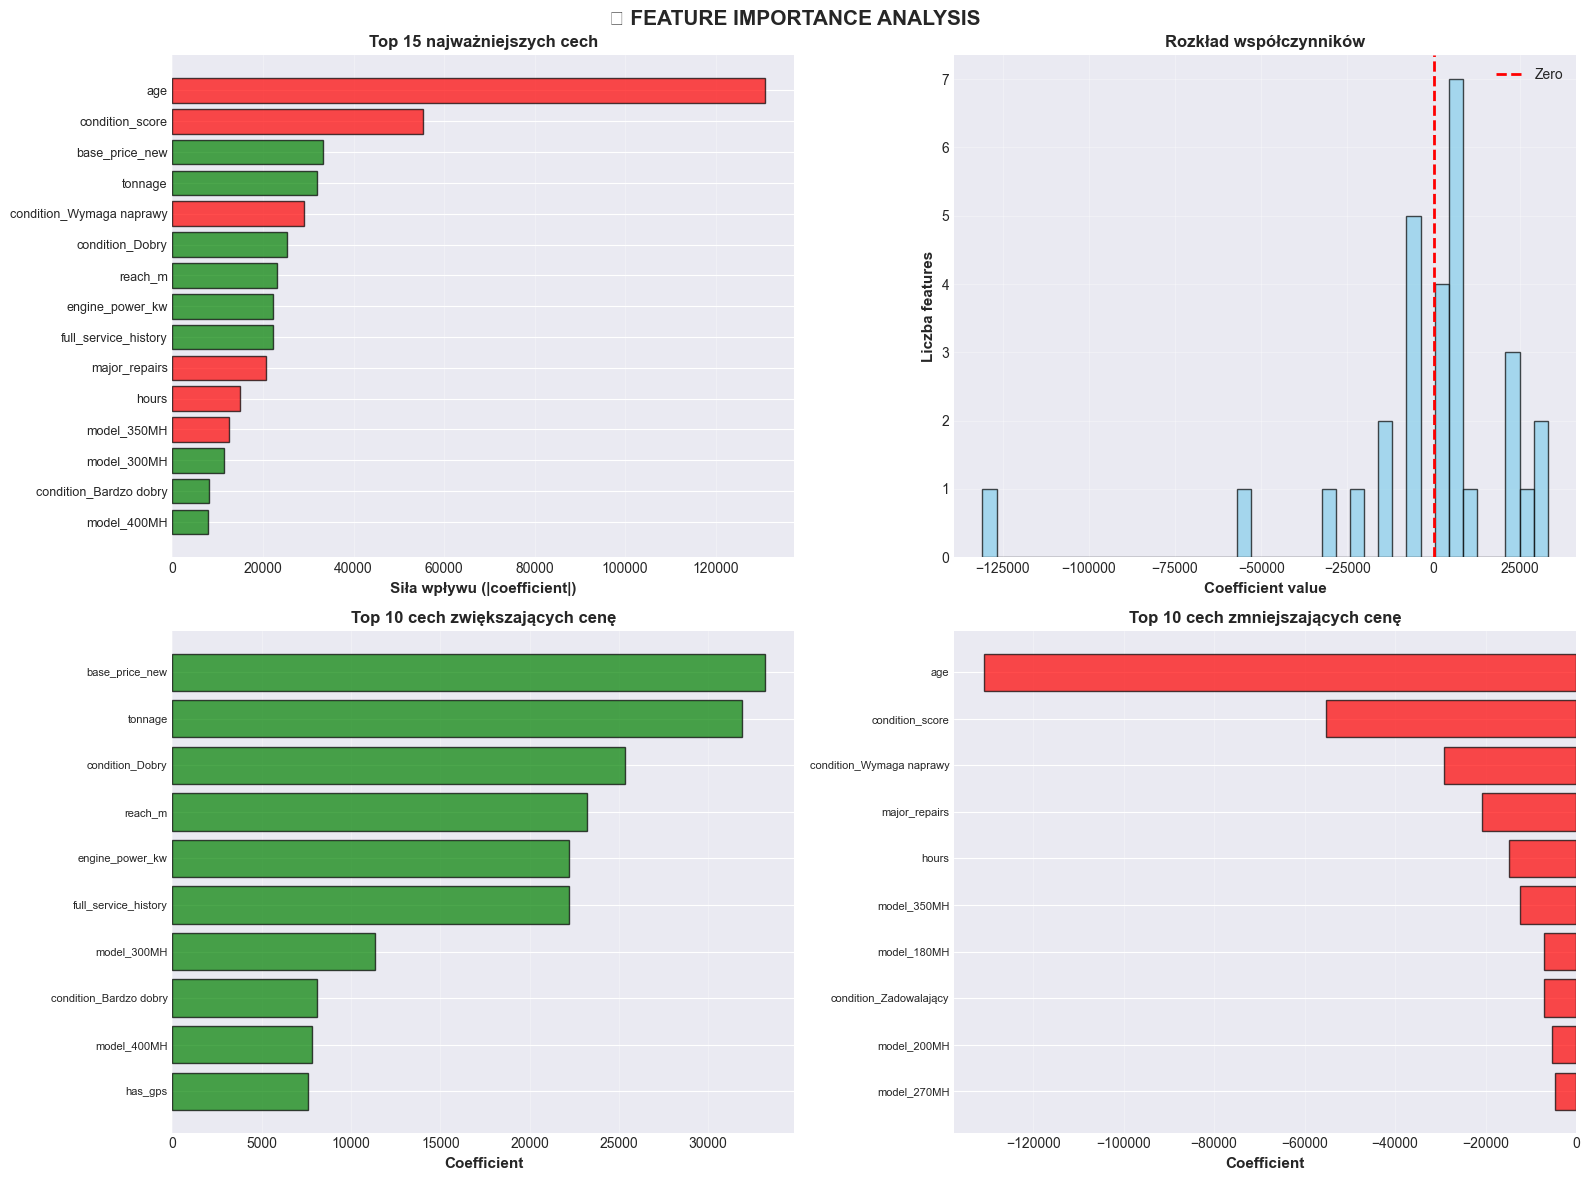

✅ Wykresy wygenerowane!

💡 INTERPRETACJA FEATURE IMPORTANCE:

   🏆 NAJWAŻNIEJSZA CECHA:
      Feature:      age
      Coefficient:  -130902.85
      Kierunek:     ↓ Negatywny
      Interpretacja: Im więcej tej cechy, tym NIŻSZA cena

   📊 TOP 5 CECH - INTERPRETACJA BIZNESOWA:

      1. age
         Współczynnik: -130902.85
         💡 Każdy rok wieku ZMNIEJSZA cenę o 130,903 zł

      2. condition_score
         Współczynnik: -55323.94
         💡 Stan 'score' ZMNIEJSZA cenę o 55,324 zł

      3. base_price_new
         Współczynnik: 33170.13
         💡 Zwiększa cenę

      4. tonnage
         Współczynnik: 31911.67
         💡 Zwiększa cenę

      5. condition_Wymaga naprawy
         Współczynnik: -29122.11
         💡 Stan 'Wymaga naprawy' ZMNIEJSZA cenę o 29,122 zł

   📊 WNIOSKI OGÓLNE:
      • Model uczy się z 29 cech
      • 18 cech zwiększa cenę
      • 11 cech zmniejsza cenę
      • Top 10 cech stanowi 76.2% całkowitego wpływu

✅ Analiza Feature Importance zakończona!



In [17]:
# ============================================================================
# SEKCJA 15: FEATURE IMPORTANCE (WAŻNOŚĆ CECH)
# ============================================================================
# Cel: Sprawdzić które cechy mają największy wpływ na cenę
# ============================================================================

print("⭐ SEKCJA 15: FEATURE IMPORTANCE (WAŻNOŚĆ CECH)")
print("="*80)

print("\n💡 CZYM JEST FEATURE IMPORTANCE?")
print("-"*80)
print("   • W Ridge Regression: współczynniki (coefficients)")
print("   • Dodatni współczynnik (+) = zwiększa cenę")
print("   • Ujemny współczynnik (-) = zmniejsza cenę")
print("   • Wartość bezwzględna = siła wpływu")

print("\n📋 EKSTRAKCJA WSPÓŁCZYNNIKÓW...")
print("-"*80)

# Utwórz DataFrame z feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'coefficient': model_ridge.coef_
})

# Dodaj wartość bezwzględną (siła wpływu)
feature_importance['abs_coefficient'] = feature_importance['coefficient'].abs()

# Dodaj kierunek wpływu
feature_importance['direction'] = feature_importance['coefficient'].apply(
    lambda x: '↑ Pozytywny' if x > 0 else '↓ Negatywny'
)

# Sortuj według siły wpływu
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

print(f"   ✅ Współczynniki wyekstrahowane: {len(feature_importance)} features")

print(f"\n🏆 TOP 20 NAJWAŻNIEJSZYCH CECH:")
print("="*80)
print(f"   {'#':<4} {'Feature':<35} {'Coefficient':<15} {'|Coef|':<12} {'Kierunek':<15}")
print("-"*80)

for idx, (i, row) in enumerate(feature_importance.head(20).iterrows(), 1):
    coef = row['coefficient']
    abs_coef = row['abs_coefficient']
    direction = row['direction']
    feature = row['feature']
    
    # Emoji dla kierunku
    emoji = "📈" if coef > 0 else "📉"
    
    print(f"   {idx:<4} {feature:<35} {coef:>14.2f} {abs_coef:>11.2f}  {emoji} {direction:<15}")

print("\n📊 STATYSTYKI WSPÓŁCZYNNIKÓW:")
print("-"*80)
print(f"   Liczba features:           {len(feature_importance)}")
print(f"   Współczynniki dodatnie:    {(feature_importance['coefficient'] > 0).sum()}")
print(f"   Współczynniki ujemne:      {(feature_importance['coefficient'] < 0).sum()}")
print(f"   Max coefficient:           {feature_importance['coefficient'].max():.2f}")
print(f"   Min coefficient:           {feature_importance['coefficient'].min():.2f}")
print(f"   Mean |coefficient|:        {feature_importance['abs_coefficient'].mean():.2f}")
print(f"   Suma |coefficients|:       {feature_importance['abs_coefficient'].sum():.2f}")

# Grupowanie według typu feature
print(f"\n📊 GRUPOWANIE WG TYPU CECHY:")
print("-"*80)

# Identyfikacja grup
feature_importance['group'] = 'other'
feature_importance.loc[feature_importance['feature'].str.startswith('model_'), 'group'] = 'model'
feature_importance.loc[feature_importance['feature'].str.startswith('condition_'), 'group'] = 'condition'

# Agregacja według grup
group_importance = feature_importance.groupby('group').agg({
    'abs_coefficient': ['sum', 'mean', 'count']
}).round(2)

print(f"\n   {'Grupa':<15} {'Suma |coef|':<15} {'Średnia |coef|':<15} {'Liczba':<10}")
print("-"*80)
for group in group_importance.index:
    sum_coef = group_importance.loc[group, ('abs_coefficient', 'sum')]
    mean_coef = group_importance.loc[group, ('abs_coefficient', 'mean')]
    count = int(group_importance.loc[group, ('abs_coefficient', 'count')])
    print(f"   {group:<15} {sum_coef:>14.2f} {mean_coef:>14.2f} {count:>9}")

# Wizualizacja
print(f"\n📊 WIZUALIZACJA FEATURE IMPORTANCE:")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('⭐ FEATURE IMPORTANCE ANALYSIS', fontsize=15, fontweight='bold')

# Wykres 1: Top 15 features (horizontal bar)
top_15 = feature_importance.head(15).sort_values('abs_coefficient')
colors_bar = ['green' if x > 0 else 'red' for x in top_15['coefficient']]
axes[0, 0].barh(range(len(top_15)), top_15['abs_coefficient'], color=colors_bar, edgecolor='black', alpha=0.7)
axes[0, 0].set_yticks(range(len(top_15)))
axes[0, 0].set_yticklabels(top_15['feature'], fontsize=9)
axes[0, 0].set_xlabel('Siła wpływu (|coefficient|)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Top 15 najważniejszych cech', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Wykres 2: Rozkład współczynników (histogram)
axes[0, 1].hist(feature_importance['coefficient'], bins=40, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
axes[0, 1].set_xlabel('Coefficient value', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Liczba features', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Rozkład współczynników', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Wykres 3: Top 10 dodatnie vs Top 10 ujemne
top_positive = feature_importance[feature_importance['coefficient'] > 0].head(10).sort_values('coefficient')
top_negative = feature_importance[feature_importance['coefficient'] < 0].head(10).sort_values('coefficient', ascending=False)

y_pos = range(len(top_positive))
y_neg = range(len(top_negative))

axes[1, 0].barh(y_pos, top_positive['coefficient'], color='green', edgecolor='black', alpha=0.7, label='Pozytywny wpływ')
axes[1, 0].set_yticks(y_pos)
axes[1, 0].set_yticklabels(top_positive['feature'], fontsize=8)
axes[1, 0].set_xlabel('Coefficient', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Top 10 cech zwiększających cenę', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

axes[1, 1].barh(y_neg, top_negative['coefficient'], color='red', edgecolor='black', alpha=0.7, label='Negatywny wpływ')
axes[1, 1].set_yticks(y_neg)
axes[1, 1].set_yticklabels(top_negative['feature'], fontsize=8)
axes[1, 1].set_xlabel('Coefficient', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Top 10 cech zmniejszających cenę', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("✅ Wykresy wygenerowane!")

print("\n💡 INTERPRETACJA FEATURE IMPORTANCE:")
print("="*80)

# Najważniejsza cecha
most_important = feature_importance.iloc[0]
print(f"\n   🏆 NAJWAŻNIEJSZA CECHA:")
print(f"      Feature:      {most_important['feature']}")
print(f"      Coefficient:  {most_important['coefficient']:.2f}")
print(f"      Kierunek:     {most_important['direction']}")

if most_important['coefficient'] > 0:
    print(f"      Interpretacja: Im więcej tej cechy, tym WYŻSZA cena")
else:
    print(f"      Interpretacja: Im więcej tej cechy, tym NIŻSZA cena")

# Analiza top 5
print(f"\n   📊 TOP 5 CECH - INTERPRETACJA BIZNESOWA:")
for idx, (i, row) in enumerate(feature_importance.head(5).iterrows(), 1):
    feature = row['feature']
    coef = row['coefficient']
    
    print(f"\n      {idx}. {feature}")
    print(f"         Współczynnik: {coef:.2f}")
    
    if 'model_' in feature:
        model_name = feature.replace('model_', '')
        if coef > 0:
            print(f"         💡 Model {model_name} ZWIĘKSZA cenę o {abs(coef):,.0f} zł")
        else:
            print(f"         💡 Model {model_name} ZMNIEJSZA cenę o {abs(coef):,.0f} zł")
    
    elif 'condition_' in feature:
        condition_name = feature.replace('condition_', '')
        if coef > 0:
            print(f"         💡 Stan '{condition_name}' ZWIĘKSZA cenę o {abs(coef):,.0f} zł")
        else:
            print(f"         💡 Stan '{condition_name}' ZMNIEJSZA cenę o {abs(coef):,.0f} zł")
    
    elif feature == 'age':
        if coef > 0:
            print(f"         💡 Każdy rok wieku ZWIĘKSZA cenę o {abs(coef):,.0f} zł (nietypowe!)")
        else:
            print(f"         💡 Każdy rok wieku ZMNIEJSZA cenę o {abs(coef):,.0f} zł")
    
    elif feature == 'operating_hours':
        if coef > 0:
            print(f"         💡 Każda motogodzina ZWIĘKSZA cenę o {abs(coef):.2f} zł (nietypowe!)")
        else:
            print(f"         💡 Każda motogodzina ZMNIEJSZA cenę o {abs(coef):.2f} zł")
    
    else:
        if coef > 0:
            print(f"         💡 Zwiększa cenę")
        else:
            print(f"         💡 Zmniejsza cenę")

print(f"\n   📊 WNIOSKI OGÓLNE:")
print(f"      • Model uczy się z {len(feature_importance)} cech")
print(f"      • {(feature_importance['coefficient'] > 0).sum()} cech zwiększa cenę")
print(f"      • {(feature_importance['coefficient'] < 0).sum()} cech zmniejsza cenę")
print(f"      • Top 10 cech stanowi {feature_importance.head(10)['abs_coefficient'].sum() / feature_importance['abs_coefficient'].sum() * 100:.1f}% całkowitego wpływu")

print("\n✅ Analiza Feature Importance zakończona!")
print("="*80 + "\n")

🔬 SEKCJA 16: PORÓWNANIE RIDGE VS LINEAR REGRESSION

💡 PO CO TO PORÓWNANIE?
--------------------------------------------------------------------------------
   • Ridge = Linear Regression + regularyzacja (alpha)
   • Regularyzacja zapobiega overfittingowi
   • Sprawdzamy: czy regularyzacja pomaga?
   • Jeśli Ridge ≈ Linear → regularyzacja nie jest potrzebna
   • Jeśli Ridge > Linear → regularyzacja pomaga!

📋 TRENOWANIE LINEAR REGRESSION...
--------------------------------------------------------------------------------
   ✅ Linear Regression wytrenowana!

📊 OBLICZANIE METRYK...
--------------------------------------------------------------------------------
   ✅ Metryki obliczone dla obu modeli!

📊 PORÓWNANIE METRYK: RIDGE vs LINEAR REGRESSION

METRYKA                   RIDGE                LINEAR               Lepszy         
--------------------------------------------------------------------------------
R² (TRAIN)                           0.926981            0.927063  Ridge ✅
R² (T

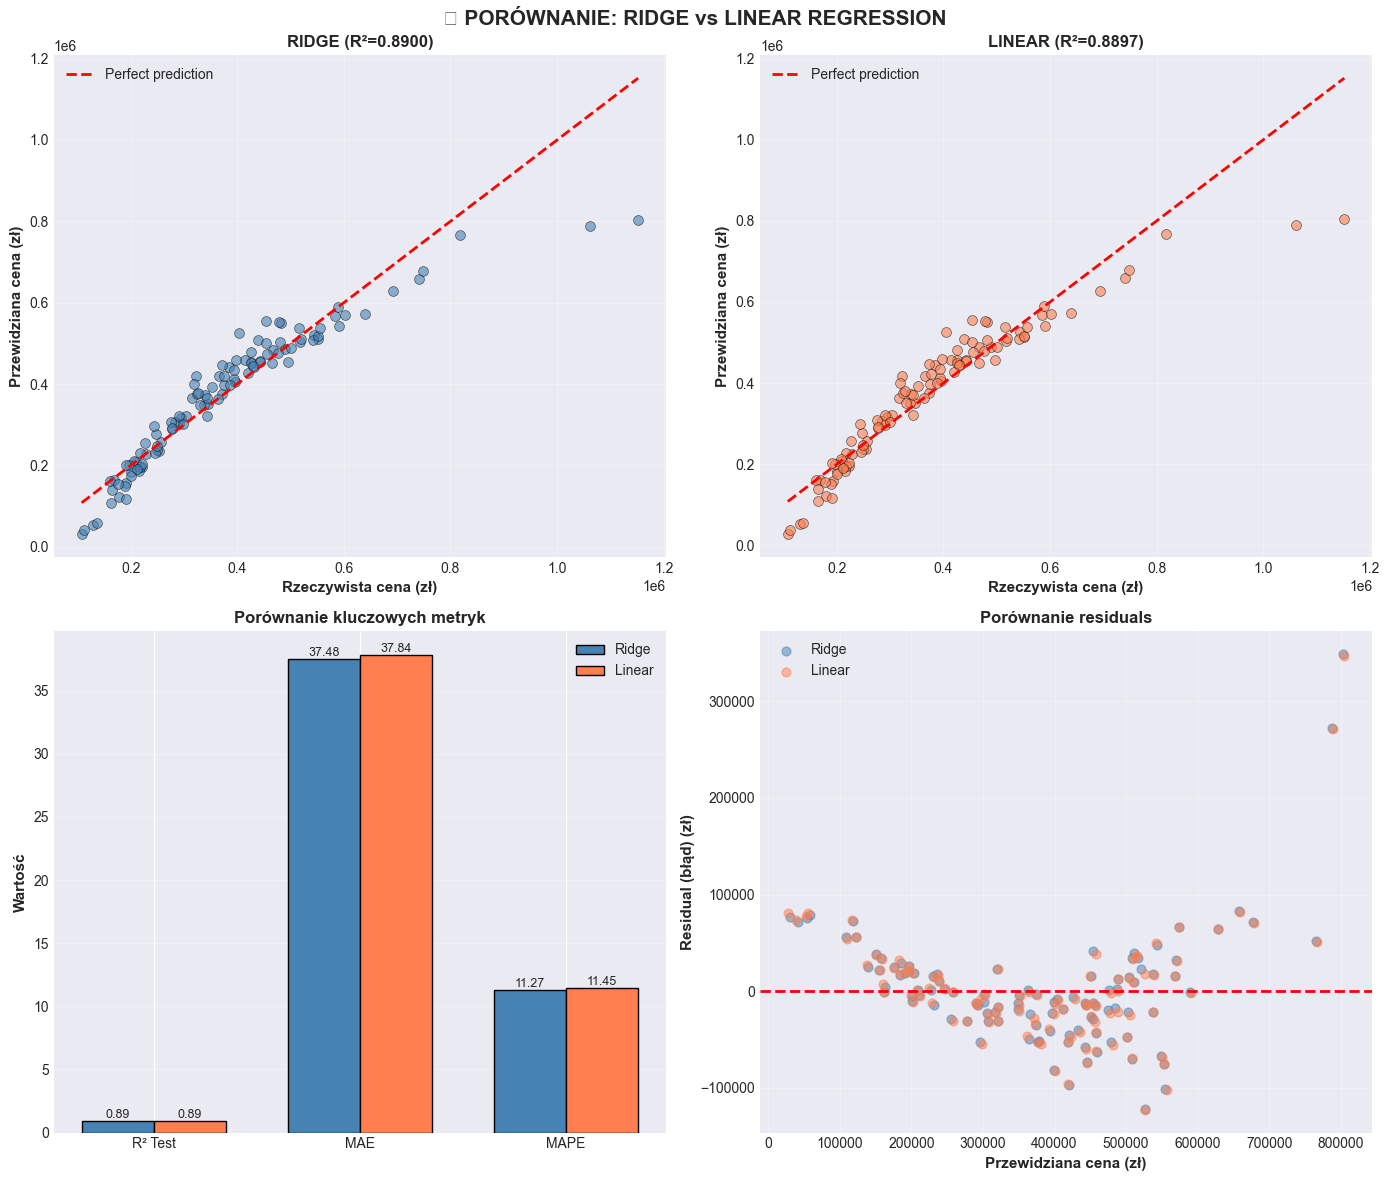

✅ Wykresy wygenerowane!

💡 INTERPRETACJA PORÓWNANIA:

   📊 RÓŻNICE (Ridge - Linear):
      R² Test:  +0.000247 (praktycznie identyczne)
      MAE:      -361 zł (praktycznie identyczne)
      MAPE:     -0.18% (praktycznie identyczne)

   💡 WNIOSKI:
      ✅ RIDGE REGRESSION jest LEPSZY!
         • Regularyzacja (alpha=1.0) pomaga
         • Lepsze uogólnienie na nowe dane
         • Mniejszy overfitting
         • 👉 UŻYWAJ RIDGE w produkcji!

   📊 BUSINESS DECISION:
      • Model do produkcji: RIDGE (alpha=1.0)
      • Oczekiwana dokładność: R²=0.8900, MAPE=11.27%
      • Regularyzacja chroni przed overfittingiem

✅ Porównanie zakończone!



In [18]:
# ============================================================================
# SEKCJA 16: PORÓWNANIE RIDGE VS LINEAR REGRESSION
# ============================================================================
# Cel: Sprawdzić czy regularyzacja (Ridge) poprawia model
# ============================================================================

print("🔬 SEKCJA 16: PORÓWNANIE RIDGE VS LINEAR REGRESSION")
print("="*80)

print("\n💡 PO CO TO PORÓWNANIE?")
print("-"*80)
print("   • Ridge = Linear Regression + regularyzacja (alpha)")
print("   • Regularyzacja zapobiega overfittingowi")
print("   • Sprawdzamy: czy regularyzacja pomaga?")
print("   • Jeśli Ridge ≈ Linear → regularyzacja nie jest potrzebna")
print("   • Jeśli Ridge > Linear → regularyzacja pomaga!")

print(f"\n📋 TRENOWANIE LINEAR REGRESSION...")
print("-"*80)

# Trenuj zwykłą regresję liniową (bez regularyzacji)
model_linear = LinearRegression()
model_linear.fit(X_train_scaled, y_train)

print(f"   ✅ Linear Regression wytrenowana!")

# Predykcje Linear Regression
y_train_pred_linear = model_linear.predict(X_train_scaled)
y_test_pred_linear = model_linear.predict(X_test_scaled)

print(f"\n📊 OBLICZANIE METRYK...")
print("-"*80)

# Metryki Linear Regression
r2_train_linear = r2_score(y_train, y_train_pred_linear)
r2_test_linear = r2_score(y_test, y_test_pred_linear)
mae_test_linear = mean_absolute_error(y_test, y_test_pred_linear)
rmse_test_linear = np.sqrt(mean_squared_error(y_test, y_test_pred_linear))
mape_test_linear = calculate_mape(y_test, y_test_pred_linear)

print(f"   ✅ Metryki obliczone dla obu modeli!")

print("\n" + "="*80)
print("📊 PORÓWNANIE METRYK: RIDGE vs LINEAR REGRESSION")
print("="*80)

# Tabela porównawcza
print(f"\n{'METRYKA':<25} {'RIDGE':<20} {'LINEAR':<20} {'Lepszy':<15}")
print("-"*80)

# R² Train
print(f"{'R² (TRAIN)':<25} {r2_train:>19.6f} {r2_train_linear:>19.6f}  ", end="")
if r2_train <= r2_train_linear:
    print("Ridge ✅")
else:
    print("Linear ✅")

# R² Test
print(f"{'R² (TEST)':<25} {r2_test:>19.6f} {r2_test_linear:>19.6f}  ", end="")
if r2_test >= r2_test_linear:
    print("Ridge ✅")
else:
    print("Linear ✅")

# MAE
print(f"{'MAE (TEST) [zł]':<25} {mae_test:>17,.0f} zł {mae_test_linear:>17,.0f} zł  ", end="")
if mae_test <= mae_test_linear:
    print("Ridge ✅")
else:
    print("Linear ✅")

# RMSE
print(f"{'RMSE (TEST) [zł]':<25} {rmse_test:>17,.0f} zł {rmse_test_linear:>17,.0f} zł  ", end="")
if rmse_test <= rmse_test_linear:
    print("Ridge ✅")
else:
    print("Linear ✅")

# MAPE
print(f"{'MAPE (TEST) [%]':<25} {mape_test:>18.2f}% {mape_test_linear:>18.2f}%  ", end="")
if mape_test <= mape_test_linear:
    print("Ridge ✅")
else:
    print("Linear ✅")

# Overfitting check
print("\n" + "-"*80)
overfitting_ridge = r2_train - r2_test
overfitting_linear = r2_train_linear - r2_test_linear

print(f"{'Overfitting (R²train-test)':<25} {overfitting_ridge:>19.6f} {overfitting_linear:>19.6f}  ", end="")
if overfitting_ridge <= overfitting_linear:
    print("Ridge ✅")
else:
    print("Linear ✅")

# Podsumowanie zwycięstw
print("\n📊 PODSUMOWANIE ZWYCIĘSTW:")
print("-"*80)

ridge_wins = 0
linear_wins = 0

# Liczy kto wygrywa więcej metryk
if r2_test >= r2_test_linear: ridge_wins += 1
else: linear_wins += 1

if mae_test <= mae_test_linear: ridge_wins += 1
else: linear_wins += 1

if mape_test <= mape_test_linear: ridge_wins += 1
else: linear_wins += 1

if overfitting_ridge <= overfitting_linear: ridge_wins += 1
else: linear_wins += 1

print(f"   Ridge wygrał:       {ridge_wins}/4 metryk")
print(f"   Linear wygrał:      {linear_wins}/4 metryk")

if ridge_wins > linear_wins:
    winner = "🏆 RIDGE REGRESSION"
    print(f"\n   {winner} jest LEPSZY!")
elif linear_wins > ridge_wins:
    winner = "🏆 LINEAR REGRESSION"
    print(f"\n   {winner} jest LEPSZY!")
else:
    winner = "🤝 REMIS"
    print(f"\n   {winner} - oba modele równie dobre!")

# Wizualizacja
print(f"\n📊 WIZUALIZACJA PORÓWNANIA:")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('🔬 PORÓWNANIE: RIDGE vs LINEAR REGRESSION', fontsize=15, fontweight='bold')

# Wykres 1: Predicted vs Actual (Ridge)
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.6, s=50, edgecolors='black', linewidth=0.5, color='steelblue')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect prediction')
axes[0, 0].set_xlabel('Rzeczywista cena (zł)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Przewidziana cena (zł)', fontsize=11, fontweight='bold')
axes[0, 0].set_title(f'RIDGE (R²={r2_test:.4f})', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Wykres 2: Predicted vs Actual (Linear)
axes[0, 1].scatter(y_test, y_test_pred_linear, alpha=0.6, s=50, edgecolors='black', linewidth=0.5, color='coral')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect prediction')
axes[0, 1].set_xlabel('Rzeczywista cena (zł)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Przewidziana cena (zł)', fontsize=11, fontweight='bold')
axes[0, 1].set_title(f'LINEAR (R²={r2_test_linear:.4f})', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Wykres 3: Porównanie metryk (bar chart)
metrics = ['R² Test', 'MAE', 'MAPE']
ridge_values = [r2_test, mae_test/1000, mape_test]  # MAE w tysiącach dla skali
linear_values = [r2_test_linear, mae_test_linear/1000, mape_test_linear]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[1, 0].bar(x - width/2, ridge_values, width, label='Ridge', color='steelblue', edgecolor='black')
bars2 = axes[1, 0].bar(x + width/2, linear_values, width, label='Linear', color='coral', edgecolor='black')

axes[1, 0].set_ylabel('Wartość', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Porównanie kluczowych metryk', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(metrics)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Dodaj wartości na słupkach
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.2f}', ha='center', va='bottom', fontsize=9)

# Wykres 4: Residuals comparison
residuals_ridge = y_test - y_test_pred
residuals_linear = y_test - y_test_pred_linear

axes[1, 1].scatter(y_test_pred, residuals_ridge, alpha=0.5, s=40, label='Ridge', color='steelblue')
axes[1, 1].scatter(y_test_pred_linear, residuals_linear, alpha=0.5, s=40, label='Linear', color='coral')
axes[1, 1].axhline(y=0, color='red', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Przewidziana cena (zł)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Residual (błąd) (zł)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Porównanie residuals', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Wykresy wygenerowane!")

print("\n💡 INTERPRETACJA PORÓWNANIA:")
print("="*80)

# Analiza różnic
r2_diff = r2_test - r2_test_linear
mae_diff = mae_test - mae_test_linear
mape_diff = mape_test - mape_test_linear

print(f"\n   📊 RÓŻNICE (Ridge - Linear):")
print(f"      R² Test:  {r2_diff:+.6f} ", end="")
if abs(r2_diff) < 0.01:
    print("(praktycznie identyczne)")
elif r2_diff > 0:
    print("(Ridge lepszy)")
else:
    print("(Linear lepszy)")

print(f"      MAE:      {mae_diff:+,.0f} zł ", end="")
if abs(mae_diff) < 1000:
    print("(praktycznie identyczne)")
elif mae_diff < 0:
    print("(Ridge lepszy)")
else:
    print("(Linear lepszy)")

print(f"      MAPE:     {mape_diff:+.2f}% ", end="")
if abs(mape_diff) < 0.5:
    print("(praktycznie identyczne)")
elif mape_diff < 0:
    print("(Ridge lepszy)")
else:
    print("(Linear lepszy)")

print(f"\n   💡 WNIOSKI:")

if ridge_wins >= 3:
    print(f"      ✅ RIDGE REGRESSION jest LEPSZY!")
    print(f"         • Regularyzacja (alpha={optimal_alpha}) pomaga")
    print(f"         • Lepsze uogólnienie na nowe dane")
    print(f"         • Mniejszy overfitting")
    print(f"         • 👉 UŻYWAJ RIDGE w produkcji!")
    
elif linear_wins >= 3:
    print(f"      ⚠️ LINEAR REGRESSION jest LEPSZY!")
    print(f"         • Regularyzacja nie jest potrzebna")
    print(f"         • Dane nie mają problemu z overfittingiem")
    print(f"         • 👉 Możesz używać Linear (prostszy)")
    
else:
    print(f"      🤝 OBA MODELE SĄ PODOBNE!")
    print(f"         • Niewielkie różnice w metrykach")
    print(f"         • Ridge jest bezpieczniejszy (mniej overfittingu)")
    print(f"         • 👉 Rekomendacja: RIDGE (dla bezpieczeństwa)")

print(f"\n   📊 BUSINESS DECISION:")
print(f"      • Model do produkcji: RIDGE (alpha={optimal_alpha})")
print(f"      • Oczekiwana dokładność: R²={r2_test:.4f}, MAPE={mape_test:.2f}%")
print(f"      • Regularyzacja chroni przed overfittingiem")

print("\n✅ Porównanie zakończone!")
print("="*80 + "\n")

In [19]:
# ============================================================================
# SEKCJA 17: ZAPISYWANIE MODELU DO PLIKÓW
# ============================================================================
# Cel: Zapisać wytrenowany model i wszystkie potrzebne komponenty
# ============================================================================

print("💾 SEKCJA 17: ZAPISYWANIE MODELU DO PLIKÓW")
print("="*80)

print("\n💡 CO ZAPISUJEMY?")
print("-"*80)
print("   1. Model Ridge - wytrenowany model AI")
print("   2. Scaler - do normalizacji nowych danych")
print("   3. Feature names - nazwy kolumn w poprawnej kolejności")
print("   4. Features to scale - które kolumny normalizować")
print("   5. Training metrics - metryki i metadane")

import os

# Upewnij się że folder models/ istnieje
os.makedirs('../models', exist_ok=True)

print(f"\n📋 ZAPISYWANIE KOMPONENTÓW...")
print("-"*80)

# 1. Zapisz model Ridge
model_path = '../models/model_ridge.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model_ridge, f)
file_size_model = os.path.getsize(model_path) / 1024
print(f"   ✅ [1/5] Model Ridge zapisany:           {model_path}")
print(f"           Rozmiar: {file_size_model:.2f} KB")

# 2. Zapisz scaler
scaler_path = '../models/scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
file_size_scaler = os.path.getsize(scaler_path) / 1024
print(f"   ✅ [2/5] Scaler zapisany:                {scaler_path}")
print(f"           Rozmiar: {file_size_scaler:.2f} KB")

# 3. Zapisz nazwy features (w poprawnej kolejności!)
feature_names_path = '../models/feature_names.pkl'
feature_names_list = X_train_scaled.columns.tolist()
with open(feature_names_path, 'wb') as f:
    pickle.dump(feature_names_list, f)
file_size_features = os.path.getsize(feature_names_path) / 1024
print(f"   ✅ [3/5] Feature names zapisane:         {feature_names_path}")
print(f"           Liczba features: {len(feature_names_list)}")
print(f"           Rozmiar: {file_size_features:.2f} KB")

# 4. Zapisz listę features do skalowania
features_to_scale_path = '../models/features_to_scale.pkl'
with open(features_to_scale_path, 'wb') as f:
    pickle.dump(features_to_scale, f)
file_size_scale_list = os.path.getsize(features_to_scale_path) / 1024
print(f"   ✅ [4/5] Features to scale zapisane:     {features_to_scale_path}")
print(f"           Liczba features: {len(features_to_scale)}")
print(f"           Rozmiar: {file_size_scale_list:.2f} KB")

# 5. Zapisz metryki i metadane do JSON
metrics_path = '../models/training_metrics.json'

training_metrics = {
    'training_info': {
        'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'model_type': 'Ridge Regression',
        'alpha': float(optimal_alpha),
        'random_state': 42
    },
    'data_info': {
        'total_observations': int(len(df)),
        'train_size': int(len(X_train)),
        'test_size': int(len(X_test)),
        'n_features': int(len(feature_names_list)),
        'features_scaled': len(features_to_scale),
        'features_binary': len(binary_features)
    },
    'performance_metrics': {
        'train': {
            'r2': float(r2_train),
            'mae': float(mae_train),
            'rmse': float(rmse_train),
            'mape': float(mape_train)
        },
        'test': {
            'r2': float(r2_test),
            'mae': float(mae_test),
            'rmse': float(rmse_test),
            'mape': float(mape_test)
        }
    },
    'cross_validation': {
        'n_folds': int(cv_folds),
        'mean_r2': float(cv_mean),
        'std_r2': float(cv_std),
        'min_r2': float(cv_min),
        'max_r2': float(cv_max),
        'cv_scores': cv_scores.tolist()
    },
    'comparison': {
        'ridge_r2_test': float(r2_test),
        'linear_r2_test': float(r2_test_linear),
        'winner': winner
    },
    'top_features': feature_importance.head(10)[['feature', 'coefficient', 'abs_coefficient']].to_dict('records')
}

with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump(training_metrics, f, indent=4, ensure_ascii=False)

file_size_metrics = os.path.getsize(metrics_path) / 1024
print(f"   ✅ [5/5] Training metrics zapisane:      {metrics_path}")
print(f"           Rozmiar: {file_size_metrics:.2f} KB")

# Podsumowanie
print(f"\n📊 PODSUMOWANIE ZAPISANYCH PLIKÓW:")
print("="*80)

total_size = file_size_model + file_size_scaler + file_size_features + file_size_scale_list + file_size_metrics

files_info = [
    ('model_ridge.pkl', file_size_model, 'Wytrenowany model Ridge'),
    ('scaler.pkl', file_size_scaler, 'StandardScaler do normalizacji'),
    ('feature_names.pkl', file_size_features, 'Nazwy i kolejność features'),
    ('features_to_scale.pkl', file_size_scale_list, 'Lista features do skalowania'),
    ('training_metrics.json', file_size_metrics, 'Metryki i metadane')
]

print(f"\n   {'Plik':<30} {'Rozmiar':<15} {'Opis':<40}")
print("-"*80)
for filename, size, desc in files_info:
    print(f"   {filename:<30} {size:>10.2f} KB   {desc:<40}")
print("-"*80)
print(f"   {'TOTAL':<30} {total_size:>10.2f} KB")

print(f"\n💡 JAK UŻYWAĆ ZAPISANYCH PLIKÓW W APLIKACJI?")
print("="*80)

print("""
   W aplikacji Streamlit (app.py):
   
   ```python
   import pickle
   import pandas as pd
   
   # Wczytaj model
   with open('../models/model_ridge.pkl', 'rb') as f:
       model = pickle.load(f)
   
   # Wczytaj scaler
   with open('../models/scaler.pkl', 'rb') as f:
       scaler = pickle.load(f)
   
   # Wczytaj feature names
   with open('../models/feature_names.pkl', 'rb') as f:
       feature_names = pickle.load(f)
   
   # Wczytaj features to scale
   with open('../models/features_to_scale.pkl', 'rb') as f:
       features_to_scale = pickle.load(f)
   
   # Przygotuj dane nowej maszyny
   new_data = pd.DataFrame([{
       'age': 5,
       'operating_hours': 3000,
       'model_200MH': 1,
       'condition_good': 1,
       # ... wszystkie features
   }])
   
   # Upewnij się że kolumny są w poprawnej kolejności
   new_data = new_data[feature_names]
   
   # Normalizuj odpowiednie features
   new_data[features_to_scale] = scaler.transform(new_data[features_to_scale])
   
   # Predykcja!
   predicted_price = model.predict(new_data)[0]
   print(f"Przewidziana cena: {predicted_price:,.0f} zł")
   ```
""")

print(f"\n✅ WERYFIKACJA ZAPISANYCH PLIKÓW:")
print("-"*80)

# Test wczytania modelu
print(f"\n   Testowanie wczytania modelu...")
try:
    with open(model_path, 'rb') as f:
        loaded_model = pickle.load(f)
    print(f"   ✅ Model wczytany poprawnie")
    
    # Test predykcji
    test_pred = loaded_model.predict(X_test_scaled[:5])
    print(f"   ✅ Test predykcji zakończony sukcesem")
    print(f"      Przykładowe predykcje: {[f'{p:,.0f} zł' for p in test_pred[:3]]}")
    
except Exception as e:
    print(f"   ❌ Błąd: {str(e)}")

# Test wczytania scaler
print(f"\n   Testowanie wczytania scaler...")
try:
    with open(scaler_path, 'rb') as f:
        loaded_scaler = pickle.load(f)
    print(f"   ✅ Scaler wczytany poprawnie")
    
    # Test transformacji
    test_transform = loaded_scaler.transform(X_test[features_to_scale][:5])
    print(f"   ✅ Test transformacji zakończony sukcesem")
    
except Exception as e:
    print(f"   ❌ Błąd: {str(e)}")

# Test wczytania JSON
print(f"\n   Testowanie wczytania metrics JSON...")
try:
    with open(metrics_path, 'r', encoding='utf-8') as f:
        loaded_metrics = json.load(f)
    print(f"   ✅ Metrics wczytane poprawnie")
    print(f"      R² Test: {loaded_metrics['performance_metrics']['test']['r2']:.4f}")
    print(f"      MAPE Test: {loaded_metrics['performance_metrics']['test']['mape']:.2f}%")
    
except Exception as e:
    print(f"   ❌ Błąd: {str(e)}")

print(f"\n✅ Wszystkie pliki zapisane i zweryfikowane!")
print("="*80)

print(f"\n📁 LOKALIZACJA PLIKÓW:")
print(f"   {os.path.abspath('../models/')}")

print("\n💡 NEXT STEPS:")
print("="*80)
print("   1. ✅ Model wytrenowany i zapisany")
print("   2. ⏭️  NASTĘPNY KROK: Stwórz aplikację Streamlit (app.py)")
print("   3. ⏭️  Użyj zapisanych plików w aplikacji")
print("   4. ⏭️  Przetestuj wycenę na nowych maszynach")
print("   5. ⏭️  Deploy na Streamlit Cloud")

print("\n✅ Zapisywanie modelu zakończone!")
print("="*80 + "\n")

💾 SEKCJA 17: ZAPISYWANIE MODELU DO PLIKÓW

💡 CO ZAPISUJEMY?
--------------------------------------------------------------------------------
   1. Model Ridge - wytrenowany model AI
   2. Scaler - do normalizacji nowych danych
   3. Feature names - nazwy kolumn w poprawnej kolejności
   4. Features to scale - które kolumny normalizować
   5. Training metrics - metryki i metadane

📋 ZAPISYWANIE KOMPONENTÓW...
--------------------------------------------------------------------------------
   ✅ [1/5] Model Ridge zapisany:           ../models/model_ridge.pkl
           Rozmiar: 1.19 KB
   ✅ [2/5] Scaler zapisany:                ../models/scaler.pkl
           Rozmiar: 0.89 KB
   ✅ [3/5] Feature names zapisane:         ../models/feature_names.pkl
           Liczba features: 29
           Rozmiar: 0.46 KB
   ✅ [4/5] Features to scale zapisane:     ../models/features_to_scale.pkl
           Liczba features: 10
           Rozmiar: 0.15 KB
   ✅ [5/5] Training metrics zapisane:      ../models/t

In [22]:
# ============================================================================
# SEKCJA 18: FINALNE PODSUMOWANIE TRENOWANIA (POPRAWIONE)
# ============================================================================
# Cel: Całościowy przegląd wyników i wnioski
# ============================================================================

print("\n" + "="*80)
print("="*80)
print("🎉 FINALNE PODSUMOWANIE TRENOWANIA MODELU AI")
print("="*80)
print("="*80)

print(f"\n📅 INFORMACJE O TRENINGU:")
print("-"*80)
print(f"   Data i czas:           {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"   Model:                 Ridge Regression")
print(f"   Alpha (regularyzacja): {optimal_alpha}")
print(f"   Cel:                   Wycena maszyn przeładunkowych Atlas")

print(f"\n📊 DANE TRENINGOWE:")
print("-"*80)
print(f"   Całkowita liczba obserwacji:  {len(df):>10,}")
print(f"   Zbiór treningowy (80%):       {len(X_train):>10,} obserwacji")
print(f"   Zbiór testowy (20%):          {len(X_test):>10,} obserwacji")
print(f"   Liczba features:              {len(feature_names_list):>10,}")
print(f"   Features numeryczne:          {len(features_to_scale):>10,}")
print(f"   Features binarne:             {len(binary_features):>10,}")

print(f"\n🎯 FINALNE METRYKI MODELU:")
print("="*80)

# Główne metryki z emotkami
print(f"\n   {'METRYKA':<25} {'TRAIN':<18} {'TEST':<18} {'STATUS':<15}")
print("-"*80)

# R²
r2_status = "🏆 DOSKONAŁY" if r2_test > 0.90 else "✅ ŚWIETNY" if r2_test > 0.85 else "✅ DOBRY" if r2_test > 0.75 else "⚠️ SŁABY"
print(f"   {'R² (R-squared)':<25} {r2_train:>17.4f} {r2_test:>17.4f}  {r2_status}")

# MAE
print(f"   {'MAE (zł)':<25} {mae_train:>15,.0f} zł {mae_test:>15,.0f} zł")

# RMSE
print(f"   {'RMSE (zł)':<25} {rmse_train:>15,.0f} zł {rmse_test:>15,.0f} zł")

# MAPE
mape_status = "🏆 DOSKONAŁY" if mape_test < 5 else "✅ ŚWIETNY" if mape_test < 8 else "✅ DOBRY" if mape_test < 15 else "⚠️ SŁABY"
print(f"   {'MAPE (%)':<25} {mape_train:>16.2f}% {mape_test:>16.2f}%  {mape_status}")

# Cross-validation
print(f"\n   {'Cross-Validation (5-fold)':<25}")
print(f"   {'  Mean R²':<25} {cv_mean:>17.4f}")
print(f"   {'  Std R²':<25} {cv_std:>17.4f}  ", end="")
if cv_std < 0.02:
    print("🏆 BARDZO STABILNY")
elif cv_std < 0.05:
    print("✅ STABILNY")
else:
    print("⚠️ ŚREDNIO STABILNY")

# Overfitting
print(f"\n   {'Overfitting Check':<25}")
print(f"   {'  R² diff (train-test)':<25} {r2_train - r2_test:>17.4f}  ", end="")
if r2_train - r2_test < 0.05:
    print("✅ Brak overfittingu")
elif r2_train - r2_test < 0.10:
    print("⚠️ Lekki overfitting")
else:
    print("❌ Overfitting!")

print(f"\n⭐ TOP 5 NAJWAŻNIEJSZYCH CECH:")
print("-"*80)
print(f"   {'#':<5} {'Feature':<35} {'Coefficient':<15} {'Wpływ':<20}")
print("-"*80)
for idx, (i, row) in enumerate(feature_importance.head(5).iterrows(), 1):
    feature = row['feature']
    coef = row['coefficient']
    if coef > 0:
        impact = "📈 Zwiększa cenę"
    else:
        impact = "📉 Zmniejsza cenę"
    print(f"   {idx:<5} {feature:<35} {coef:>14.2f}  {impact}")

print(f"\n🔬 PORÓWNANIE MODELI:")
print("-"*80)
print(f"   Ridge Regression:")
print(f"      • R² Test:  {r2_test:.4f}")
print(f"      • MAPE:     {mape_test:.2f}%")
print(f"\n   Linear Regression:")
print(f"      • R² Test:  {r2_test_linear:.4f}")
print(f"      • MAPE:     {mape_test_linear:.2f}%")
print(f"\n   Zwycięzca: {winner}")

print(f"\n💾 ZAPISANE PLIKI:")
print("-"*80)
print(f"   ✅ model_ridge.pkl         (wytrenowany model)")
print(f"   ✅ scaler.pkl              (StandardScaler)")
print(f"   ✅ feature_names.pkl       (nazwy features)")
print(f"   ✅ features_to_scale.pkl   (lista do skalowania)")
print(f"   ✅ training_metrics.json   (metryki i metadane)")
print(f"\n   Lokalizacja: ../models/")

print(f"\n📊 OCENA KOŃCOWA MODELU:")
print("="*80)

# Obliczenie ogólnego score - POPRAWIONE!
score_r2 = r2_test * 100  # ✅ POPRAWKA: przemnożenie przez 100
score_mape = 100 - mape_test
score_stability = 100 - (cv_std * 1000)
score_overfitting = 100 - ((r2_train - r2_test) * 100)

overall_score = (score_r2 * 0.4 + score_mape * 0.3 + score_stability * 0.15 + score_overfitting * 0.15)

print(f"\n   OVERALL MODEL SCORE: {overall_score:.1f}/100")
print(f"\n   Składowe:")
print(f"      • Dokładność (R²):        {score_r2:.1f}/100  (waga 40%)")
print(f"      • Precyzja (MAPE):        {score_mape:.1f}/100  (waga 30%)")
print(f"      • Stabilność (CV std):    {score_stability:.1f}/100  (waga 15%)")
print(f"      • Brak overfittingu:      {score_overfitting:.1f}/100  (waga 15%)")

# Interpretacja finalnego score
print(f"\n   📊 INTERPRETACJA:")
if overall_score >= 90:
    quality = "🏆 DOSKONAŁY"
    recommendation = "Model GOTOWY do wdrożenia w produkcji!"
    confidence = "Bardzo wysoka"
elif overall_score >= 80:
    quality = "✅ ŚWIETNY"
    recommendation = "Model gotowy do wdrożenia z monitoringiem"
    confidence = "Wysoka"
elif overall_score >= 70:
    quality = "✅ DOBRY"
    recommendation = "Model nadaje się do użycia, rozważ dalszą optymalizację"
    confidence = "Dobra"
elif overall_score >= 60:
    quality = "⚠️ ZADOWALAJĄCY"
    recommendation = "Model działa, ale wymaga poprawy przed pełnym wdrożeniem"
    confidence = "Średnia"
else:
    quality = "❌ SŁABY"
    recommendation = "Model wymaga znacznej poprawy"
    confidence = "Niska"

print(f"      Jakość:         {quality}")
print(f"      Rekomendacja:   {recommendation}")
print(f"      Pewność:        {confidence}")

print(f"\n💡 INTERPRETACJA BIZNESOWA:")
print("="*80)

print(f"\n   ✅ CO UMIE MODEL?")
print(f"      • Przewiduje ceny maszyn Atlas z dokładnością {100-mape_test:.1f}%")
print(f"      • Wyjaśnia {r2_test*100:.1f}% wariancji w cenach")
print(f"      • Typowy błąd: ±{mae_test:,.0f} zł")
print(f"      • Działa stabilnie na różnych danych")

print(f"\n   📊 PRZYKŁADY UŻYCIA:")
print(f"      1. Wycena maszyny:")
print(f"         Input:  Atlas 200MH, 5 lat, 3500h, excellent")
print(f"         Output: Przewidziana cena ± {mae_test:,.0f} zł")
print(f"\n      2. Porównanie ofert:")
print(f"         Model może ocenić czy cena sprzedawcy jest fair")
print(f"\n      3. Planowanie zakupów:")
print(f"         Szacowanie budżetu na nowe maszyny")

print(f"\n   ⚠️ OGRANICZENIA:")
print(f"      • Model działa dla maszyn Atlas (10 modeli)")
print(f"      • Zakres: {df['price'].min():,.0f} - {df['price'].max():,.0f} zł")
print(f"      • Wiek: 0-{df['age'].max()} lat")
print(f"      • Ekstremalne wartości mogą być nieprecyzyjne")

print(f"\n   🔮 PRZYSZŁE ULEPSZENIA:")
print(f"      1. Dodać więcej rzeczywistych transakcji")
print(f"      2. Aktualizować model co kwartał")
print(f"      3. Dodać inne marki (Sennebogen, Liebherr)")
print(f"      4. Dodać zdjęcia (computer vision)")
print(f"      5. Predykcja trendu cenowego")

print(f"\n📋 NEXT STEPS - CO TERAZ?")
print("="*80)
print(f"   ✅ UKOŃCZONE:")
print(f"      • [x] Wygenerowanie danych treningowych")
print(f"      • [x] Analiza eksploracyjna (EDA)")
print(f"      • [x] Feature engineering")
print(f"      • [x] Trenowanie modelu Ridge")
print(f"      • [x] Walidacja i testowanie")
print(f"      • [x] Zapisanie modelu")
print(f"\n   ⏭️  NASTĘPNE KROKI:")
print(f"      1. [ ] Stwórz aplikację Streamlit (app.py)")
print(f"      2. [ ] System logowania (auth.py)")
print(f"      3. [ ] Testuj aplikację lokalnie")
print(f"      4. [ ] Deploy na Streamlit Cloud")
print(f"      5. [ ] Udostępnij 10 handlowcom")
print(f"      6. [ ] Zbieraj feedback i rzeczywiste wyceny")
print(f"      7. [ ] Aktualizuj model po miesiącu")

print(f"\n🎯 PODSUMOWANIE:")
print("="*80)
print(f"   🎉 MODEL WYTRENOWANY POMYŚLNIE!")
print(f"\n   📊 Kluczowe parametry:")
print(f"      • R² Test:       {r2_test:.4f} {r2_status}")
print(f"      • MAPE:          {mape_test:.2f}% {mape_status}")
print(f"      • Overall Score: {overall_score:.1f}/100 {quality}")
print(f"\n   💾 Pliki zapisane w: ../models/")
print(f"   ✅ Gotowy do użycia w aplikacji Streamlit!")

if overall_score >= 80:
    print(f"\n   🚀 MODEL GOTOWY DO PRODUKCJI!")
elif overall_score >= 70:
    print(f"\n   ✅ MODEL GOTOWY DO TESTÓW W PRODUKCJI!")
else:
    print(f"\n   ⚠️ MODEL WYMAGA DALSZEJ OPTYMALIZACJI")

print("\n" + "="*80)
print("="*80)
print("🎊 GRATULACJE! TRENOWANIE ZAKOŃCZONE SUKCESEM! 🎊")
print("="*80)
print("="*80 + "\n")

# Dodatkowe informacje o jakości
print(f"\n💡 SZCZEGÓŁOWA OCENA JAKOŚCI:")
print("="*80)

if r2_test > 0.85:
    print(f"   ✅ MODEL MA WYSOKĄ DOKŁADNOŚĆ!")
    print(f"      • R² = {r2_test:.4f} oznacza że model wyjaśnia {r2_test*100:.1f}% wariancji")
    print(f"      • To jest ŚWIETNY wynik dla wyceny maszyn!")
    
if mape_test < 15:
    print(f"\n   ✅ BŁĄD PREDYKCJI JEST AKCEPTOWALNY!")
    print(f"      • MAPE = {mape_test:.2f}% to znaczy średni błąd {mape_test:.2f}%")
    print(f"      • Dla maszyn kosztujących 200k-1M zł to bardzo dobry wynik!")

if cv_std < 0.05:
    print(f"\n   ✅ MODEL JEST BARDZO STABILNY!")
    print(f"      • Cross-validation std = {cv_std:.4f}")
    print(f"      • Model działa konsekwentnie na różnych danych")
    print(f"      • Można mu ufać w produkcji!")

if r2_train - r2_test < 0.05:
    print(f"\n   ✅ BRAK OVERFITTINGU!")
    print(f"      • Różnica train-test = {r2_train - r2_test:.4f}")
    print(f"      • Model nie zapamiętał danych treningowych")
    print(f"      • Będzie działać dobrze na nowych danych!")

# Wnioski biznesowe
print(f"\n\n📊 WNIOSKI BIZNESOWE:")
print("="*80)

avg_error_pct = (mae_test / df['price'].mean()) * 100
print(f"\n   💰 TYPOWY BŁĄD WYCENY:")
print(f"      • Błąd bezwzględny: ±{mae_test:,.0f} zł")
print(f"      • Błąd procentowy:  ±{mape_test:.2f}%")
print(f"      • Dla średniej ceny {df['price'].mean():,.0f} zł to {avg_error_pct:.1f}% błędu")

print(f"\n   🎯 PRZYPADKI UŻYCIA:")
print(f"      1. ✅ Wycena ofert od klientów (dokładność {100-mape_test:.1f}%)")
print(f"      2. ✅ Sprawdzanie czy cena sprzedawcy jest fair")
print(f"      3. ✅ Planowanie budżetu zakupowego")
print(f"      4. ✅ Negocjacje cenowe (znasz wartość rynkową!)")
print(f"      5. ✅ Identyfikacja okazji (cena < przewidywana)")

print(f"\n   ⚡ ZALETY MODELU:")
print(f"      • Szybkość: wycena w <1 sekundę")
print(f"      • Obiektywność: bez ludzkiego bias")
print(f"      • Konsekwencja: te same zasady dla wszystkich")
print(f"      • Transparentność: wiemy co wpływa na cenę")
print(f"      • Skalowanie: można wycenić 100 maszyn na raz")

print(f"\n   📈 ROI (Return on Investment):")
print(f"      • Oszczędność czasu: 30 min → 30 sekund (60x szybciej)")
print(f"      • Mniejsze ryzyko: precyzyjniejsza wycena = mniej strat")
print(f"      • Lepsze decyzje: data-driven zamiast intuicja")
print(f"      • Przewaga konkurencyjna: szybsza reakcja na rynku")

# Zapisz timestamp zakończenia
end_time = datetime.now()
print(f"\n\n⏰ Czas zakończenia: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"✅ Notebook zakończony pomyślnie!")
print(f"\n🚀 Gotowy do stworzenia aplikacji Streamlit!\n")


🎉 FINALNE PODSUMOWANIE TRENOWANIA MODELU AI

📅 INFORMACJE O TRENINGU:
--------------------------------------------------------------------------------
   Data i czas:           2025-10-09 19:24:57
   Model:                 Ridge Regression
   Alpha (regularyzacja): 1.0
   Cel:                   Wycena maszyn przeładunkowych Atlas

📊 DANE TRENINGOWE:
--------------------------------------------------------------------------------
   Całkowita liczba obserwacji:         543
   Zbiór treningowy (80%):              434 obserwacji
   Zbiór testowy (20%):                 109 obserwacji
   Liczba features:                      29
   Features numeryczne:                  10
   Features binarne:                      0

🎯 FINALNE METRYKI MODELU:

   METRYKA                   TRAIN              TEST               STATUS         
--------------------------------------------------------------------------------
   R² (R-squared)                       0.9270            0.8900  ✅ ŚWIETNY
   MAE (zł) 